## Mapping sex linked tags to the <i> Rana temporaria </i> "chromosome-assigned scaffolds" from the MST map linkage maps

In this notebook we:

1. extract the information from the mapping summary using the R temporaria MSTmap linkage map to find which scaffolds belong to which Xenopus chromosome and then produce a fasta file of all Rtemp scaffolds that could be placed.
2. Map the sex linked tags from the species which passed the sex-assignment randomisation tests to the placed Rtemp genome scaffolds
3. For each species, sample 1000 subsets of randomly chosen RADtags (each subset being the same size as the set of sex linked markers) and map them to the ordered scaffolds. This will give us an empirical null distribution of the false positive mapping rate for each species RAD dataset and each chromosome separately. 



In [188]:
%matplotlib inline
from Bio import SeqIO
from collections import Counter
import operator
from __future__ import division
import numpy as np

In [189]:
ordered_map = open("/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/All_fams_MALE_LG_mapping_summary.tsv", 'r').readlines()
Rtemp_scaffs = SeqIO.parse(open("/home/djeffrie/Data/Genomes/Rtemp/Rtemp_gapfilled.iter2.fa",'r'), "fasta")

### Just getting some stats for the paper

1. How many tags in the combined MSTmap linkage maps?

2. How many tags could be mapped to scaffolds in Rtemp.

3. How many Rtemp scaffolds could be mapped to N. parkeri

4. How many parkeri scaffolds could be mapped to Xen. 

5. How many scaffs could be placed on a Xen chrom withough being mapped. . . ?


### 1.


In [193]:
tags = []
for i in ordered_map[1:]:
    if i.split()[2] not in tags:
        tags.append(i.split()[2])
        
print "N tags in combined linkage maps = %s" % len(tags)

N tags in combined linkage maps = 15248


### 2. 

In [197]:
Rtemp_scaffs = []
for i in ordered_map[1:]:
    if "scaffold" in i.split()[3] and i.split()[3] not in Rtemp_scaffs:
        Rtemp_scaffs.append(i.split()[3])
        
print "N scaffolds with an aligned linkage map marker = %s" % len(Rtemp_scaffs)

N scaffolds with an aligned linkage map marker = 7169


### 3. 

In [201]:
Nano_scaffs = []
for i in ordered_map[1:]:
    if "scaffold" in i.split()[4]:
        Nano_scaffs.append(i.split()[4])
        
print "N Rtemp scaffolds which aligned to Nanorana = %s" % len(Nano_scaffs)
print "N Nanorana scaffolds with an aligned linkage mapped Rtemp scaffold = %s" % len(set(Nano_scaffs))

N Rtemp scaffolds which aligned to Nanorana = 5638
N Nanorana scaffolds with an aligned linkage mapped Rtemp scaffold = 1451


### 4. 

In [216]:
Xen_mappings = []
for i in ordered_map[1:]:
    
    if "Chr" in i.split()[5]:
        Xen_mappings.append(i.split()[4])
        
print "Number of Nanorana scaffolds aligned to Xenopus = %s" % len(set(Xen_mappings))

Number of Nanorana scaffolds aligned to Xenopus = 517


Note here, that it is possible that an Rtemp scaffold a) has multiple RADtags mapping to it and so is present in the mapping summary multiple times, and b) has conflicting positions. If both a) and b) are true then this mapping will be discarded. 

In [24]:
Rtemp_scaff_locations = {}
for i in ordered_map[1:]:
    Rtemp_scaff = i.split()[3]
    Xen_chrom = i.split()[6]
    
    if Rtemp_scaff != "-":
        if Rtemp_scaff not in Rtemp_scaff_locations:
            Rtemp_scaff_locations[Rtemp_scaff] = []
        Rtemp_scaff_locations[Rtemp_scaff].append(Xen_chrom)


In [55]:
Rtemp_scaff_locations_kept1 = {}
for scaff in Rtemp_scaff_locations:
    if len(set(Rtemp_scaff_locations[scaff]))>1 :
        #print Rtemp_scaff_locations[scaff]
        count = Counter(Rtemp_scaff_locations[scaff])
        max_scaff_pos = count[max(count.iteritems(), key=operator.itemgetter(1))[0]]
        min_scaff_pos = count[min(count.iteritems(), key=operator.itemgetter(1))[0]]
        
        if max_scaff_pos > min_scaff_pos+1:
            Rtemp_scaff_locations_kept[scaff] = count.most_common()[0][0]
    else:
        Rtemp_scaff_locations_kept[scaff] = Rtemp_scaff_locations[scaff]

Removing some scaffolds with conflicting mappings removes about 300 scaffolds. 


Now then I will extract scaffolds from the Rtemp genome and add to a new file along with its Xenopus chromosome and linkage map position in the header

In [70]:
ordered_fasta = open("/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta", 'w')

for record in Rtemp_scaffs:
    if record.id in Rtemp_scaff_locations_kept:
        record.id = "Xen_%s_Rtemp_%s" % (Rtemp_scaff_locations_kept[record.id][0], record.id)
        SeqIO.write(record, ordered_fasta, "fasta")

ordered_fasta.close()



Ok done, so what are the stats of the new ordered genome file . . . ?

In [78]:
Rtemp_ordered = SeqIO.parse(open("/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta",'r'), "fasta")

In [79]:
total_length = 0
scaff_count = 0
for record in Rtemp_ordered:
    scaff_count += 1
    total_length += len(record.seq)
    
print "Number of scaffolds ordered = %s" % scaff_count
print "Total length of ordered genome = %s Mb" % str(total_length/1000000)

Number of scaffolds ordered = 6855
Total length of ordered genome = 408 Mb


So thats just less than 10% of the genome . . . Lets see how interesting that is. 

### So below we define the function Null mapper - see the docstring ( run help(Null_mapper) )  for the exlpanation of what it does

In [154]:
def Null_mapper(sex_linked_markers_path, catalog_path, Genome_fasta, Genome_db, Eval = 1e-20, N_its = 10, Species = "", Threads = 1):
    
    """
    This function takes a set of sex linked (SL) markers and maps them against the ordered Xenopus genome. It also retrieves <N_its> * random subsets of markers
    from the Stacks RADseq catalog of the same size as the set of SL markers and maps them to the genome. This essentially gives a null distribution for
    the number of hits to expect from randomly selected markers in the genome. Thus, if the number of SL markers which map to a given chromosome is
    significantly higher than this null distrubution, this is good support for these markers indeed being sex linked.    
    
    Note it is not a general function, it is a function which require 1) 10 chromosomes in the reference genome ordering, 2) the 
    right format of scaffold name. 
    
    sex_linked_markers_path - Path to a fasta of sequences of interest
    catalog_path            - Path to the stacks catalog file
    Genome_fasta            - Path to the fasta for the genome
    Genome_db               - Path to the blastn index of the genome
    N_its                   - Number of random mappings to perform
    Species                 - Name of the species
    Threads                 - Number of threads to use in the mapping step
    
    
    """
    
    
    import gzip
    import random
    import os
    import numpy as np
    from collections import Counter 
    from Bio.Blast.Applications import NcbiblastnCommandline
    from matplotlib import pyplot as plt
    import gzip
    import shutil
    import MISC_RAD_tools as MISC

    
    ## First, get the IDs of the sex linked tags.

    sex_linked_markers = open(sex_linked_markers_path, 'r').readlines()

    SL_tag_IDs = []

    for line in sex_linked_markers:
        if ">" in line:
            SL_tag_ID = line.split("_")[2]
            if SL_tag_ID not in SL_tag_IDs:
                SL_tag_IDs.append(SL_tag_ID)

    print "Got %s sex-linked tag IDs" % (len(set(SL_tag_IDs)))
    
    
    ## Then get the IDs of the tags in the catalog

    catalog = gzip.open(catalog_path, 'r').readlines()[1:]

    cat_tag_IDs = []

    for line in catalog:
        cat_tag_ID = line.split()[2]
        cat_tag_IDs.append(cat_tag_ID)

    print "\nGot %s catalog tag IDs" % (len(cat_tag_IDs))
    
    
    ## Now remove the sex linked markers from the catalog tags
    counter = 0
    for i in SL_tag_IDs:
        if i in cat_tag_IDs:
            cat_tag_IDs.remove(i)
            counter += 1

    print "\nRemoved %s tags from catalog tags" % counter
    
    ## Now get "N" random samples of tags of the same size as the number of sex linked markers.


    
    random_samples = {}
    paths = {}
    file_strings = {}
    
    N = N_its
    
    print "\nMaking %s fasta files" % N

        
    ## Ok, so now I need to get these markers from the catalog and make fasta's for the mapping. Need to do this efficiently
    

    catalog_lines = []

    for tag in catalog:
        tagID =  tag.split()[2]
        seq = tag.split()[8]
        cat_line = ">%s\n%s\n" % (tagID, seq)
        catalog_lines.append(cat_line)

    wd = "%s/Random_tags/" % sex_linked_markers_path.rpartition("/")[0]

    if not os.path.exists(wd):
        os.mkdir(wd) 

    for i in range(N_its):
        random_sample = random.sample(catalog_lines, len(SL_tag_IDs))    
        
        with open("%s/random_sample_%s.fasta" % (wd, i), 'w') as fh:
            for line in random_sample:
                fh.write(line)
    
    print "\nDoing %s Random mapping iterations" % N

    
    ## Now I need to do the mapping and catch the outputs

    ## First get fasta paths

    fasta_paths = []
    N_fastas = 0
    for root, dirs, files in os.walk(wd):
        for fasta in files:
            if fasta.endswith("fasta"):
                if N_fastas <= N:
                    fasta_paths.append("%s/%s" % (root, fasta))
                    N_fastas += 1
                    
    ## Set mapping filtering criteria (can make these options later if needed)

    best_hit_crit = 1e-5
    Eval_threshold = Eval
    Window = 2000

    ## Set up dictionary to catch blast results

    blastn_outs_dict = {}  ## fasta paths can be the dictionary keys

    counter = 1
    for fasta in sorted(fasta_paths):

        print "\nBlasting %s (%s of %s)\n" % (fasta, counter, N)

        blast_out_path = "%s_blastn.xml" % fasta.rpartition(".")[0]

        blastn_cline = NcbiblastnCommandline(query=fasta, db=Genome_db, outfmt=5, out=blast_out_path, num_threads = Threads)
        stdout, stderr = blastn_cline()

        blastn_outs_dict[fasta] = MISC.BlastParseExtra(blast_out_path, Genome_fasta , best_hit_crit, Eval_threshold,Window)
        
        counter += 1

        
        ## gzip the fasta
        with open(fasta, 'rb') as f_in:
            with gzip.open("%s.gz" % fasta, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(fasta)
        
        ## gzip the xml output
        with open(blast_out_path, 'rb') as f_in:
            with gzip.open("%s.gz" % blast_out_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(blast_out_path)
                
                
        
    ## And now map the real sex linked tags

    print "\nBlasting real sex linked markers\n"
    
    real_SLM_blast_out_path = "%s_REAL_SL_TAG_blastn_outs.xml" % sex_linked_markers_path.rpartition(".")[0]

    blastn_cline = NcbiblastnCommandline(query=sex_linked_markers_path, db=Genome_db, outfmt=5, out=real_SLM_blast_out_path, num_threads = Threads)
    stdout, stderr = blastn_cline()

    Real_SL_tag_blastouts =  MISC.BlastParseExtra(real_SLM_blast_out_path, Genome_fasta , best_hit_crit, Eval_threshold,Window)

    print "\nReal sex linked marker blastn outputs are here: %s" % real_SLM_blast_out_path

    
    ## Now count the number of mappings per chromosome across the randomised marker samples
    
    All_mapping_counts = {}

    All_mapping_counts["Chr01"] = []
    All_mapping_counts["Chr02"] = []
    All_mapping_counts["Chr03"] = []
    All_mapping_counts["Chr04"] = []
    All_mapping_counts["Chr05"] = []
    All_mapping_counts["Chr06"] = []
    All_mapping_counts["Chr07"] = []
    All_mapping_counts["Chr08"] = []
    All_mapping_counts["Chr09"] = []
    All_mapping_counts["Chr10"] = []

    for i in blastn_outs_dict: ## for each mapping run

        ### Get the mapping counts per chromosome

        Xen_chroms = {}

        Xen_chroms["Chr01"] = 0
        Xen_chroms["Chr02"] = 0
        Xen_chroms["Chr03"] = 0
        Xen_chroms["Chr04"] = 0
        Xen_chroms["Chr05"] = 0
        Xen_chroms["Chr06"] = 0
        Xen_chroms["Chr07"] = 0
        Xen_chroms["Chr08"] = 0
        Xen_chroms["Chr09"] = 0
        Xen_chroms["Chr10"] = 0


        
        hits = []
        hit_Xen_scaff = []

        for record in blastn_outs_dict[i]:
            hits.append(blastn_outs_dict[i][record]["Ref_hit_id"])
            hit_Xen_scaff.append(blastn_outs_dict[i][record]["Ref_hit_id"].split("_")[1])

        counts = Counter(hit_Xen_scaff)

        for chrom in Xen_chroms:
            if chrom in counts:
                Xen_chroms[chrom] = counts[chrom]

        for chrom in Xen_chroms:
            All_mapping_counts[chrom].append(Xen_chroms[chrom])

    ## And do the same for the real sex linked markers

    hits = []
    hit_Xen_scaff = []

    for i in Real_SL_tag_blastouts:
        hits.append(Real_SL_tag_blastouts[i]["Ref_hit_id"])
        hit_Xen_scaff.append(Real_SL_tag_blastouts[i]["Ref_hit_id"].split("_")[1])

    print "\nNumber of hits =", len(hits) 

    counts = Counter(hit_Xen_scaff)

    Real_SL_tagXen_chroms = {}

    Real_SL_tagXen_chroms["Chr01"] = 0
    Real_SL_tagXen_chroms["Chr02"] = 0
    Real_SL_tagXen_chroms["Chr03"] = 0
    Real_SL_tagXen_chroms["Chr04"] = 0
    Real_SL_tagXen_chroms["Chr05"] = 0
    Real_SL_tagXen_chroms["Chr06"] = 0
    Real_SL_tagXen_chroms["Chr07"] = 0
    Real_SL_tagXen_chroms["Chr08"] = 0
    Real_SL_tagXen_chroms["Chr09"] = 0
    Real_SL_tagXen_chroms["Chr10"] = 0


    for i in Real_SL_tagXen_chroms:
        if i in counts:
            Real_SL_tagXen_chroms[i] = counts[i]
    
    
    # And now then I just need to plot this as box plots

    fig = plt.figure(figsize=(20,10), frameon = False, edgecolor = 'none')
    ax = plt.subplot(111)
    pos = 1
    col = "white"
    
    
    max_y = max([max(i) for i in All_mapping_counts.values()] + Real_SL_tagXen_chroms.values()) + 3
    
    for i in sorted(All_mapping_counts.keys()):

        if col == "grey":
            col = "white"
        elif col == "white":
            col = "grey"
        
        ax.bar(left = pos-0.5, width = 1, height= max_y, color= col, edgecolor = col, bottom = 0, alpha = 0.2, zorder = 1)
        vio = ax.violinplot(All_mapping_counts[i], positions=[pos], showmeans = True, showextrema = False )
        
        for pc in vio['bodies']:
            pc.set_facecolor('khaki')
            pc.set_edgecolor('black')
            pc.set_zorder(2)    
            pc.set_alpha(1)
        
        ax.scatter(pos, Real_SL_tagXen_chroms[i], s = 60, zorder = 3, c = "royalblue")
        
        if Real_SL_tagXen_chroms[i] > np.percentile(All_mapping_counts[i], 99):
            ax.plot(pos-0.05, max([max(i) for i in All_mapping_counts.values()] + Real_SL_tagXen_chroms.values()) + 2, "*r", zorder = 3)
            ax.plot(pos+0.05, max([max(i) for i in All_mapping_counts.values()] + Real_SL_tagXen_chroms.values()) + 2, "*r", zorder = 3)
        elif Real_SL_tagXen_chroms[i] > np.percentile(All_mapping_counts[i], 95):
            ax.plot(pos, max([max(i) for i in All_mapping_counts.values()] + Real_SL_tagXen_chroms.values()) + 2, "*r", zorder = 3)
        
        pos += 1

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left spines
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(0, 11)
    ax.set_ylim(-1, max([max(i) for i in All_mapping_counts.values()] + Real_SL_tagXen_chroms.values()) + 3)
    ax.set_xticks(range(1,11))
    ax.set_xticklabels(sorted(All_mapping_counts.keys()))
    ax.set_xlabel("Xenopus chromosome", labelpad=20)
    ax.set_ylabel("Number of mapped markers",labelpad=20)
    ax.get_xaxis().set_tick_params(which='both', direction='out', pad = 15, bottom = 'off', top = 'off')
    plt.title(Species)

    plt.savefig("%s/Per_chromosome_mappings.svg" %  sex_linked_markers_path.rpartition("/")[0])
    
    plt.show()
    
    print "\nAll done, figure saved as svg here: %s/Per_chromosome_mappings_test.svg" %  sex_linked_markers_path.rpartition("/")[0]
    
    return Real_SL_tagXen_chroms, All_mapping_counts

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Now, we run Null_mapper for each sex linked marker set that passed the sex-assignment randomisations. 

## Rana chiricahuensis

Got 37 sex-linked tag IDs

Got 1515585 catalog tag IDs

Removed 37 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 2

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 0

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 0

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 1

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_101.fasta (5 of 1000)

Number o

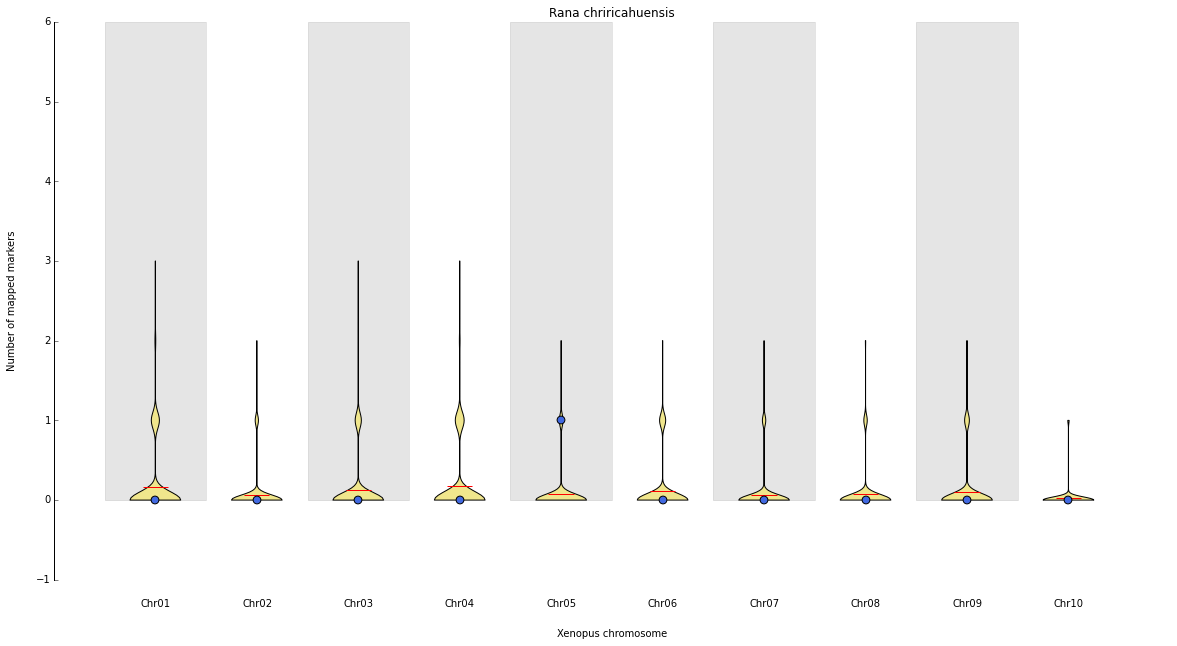


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Per_chromosome_mappings_test.svg


In [39]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Lchricahuensis/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_chiricahuensis.fa"
mySpecies = "Rana chriricahuensis"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

### Rana montezumae all XY

Got 2374 sex-linked tag IDs

Got 223805 catalog tag IDs

Removed 2374 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 22

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 7
Number of unique alingments kept: 21

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 5
Number of unique alingments kept: 17

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags//random_sample_100.

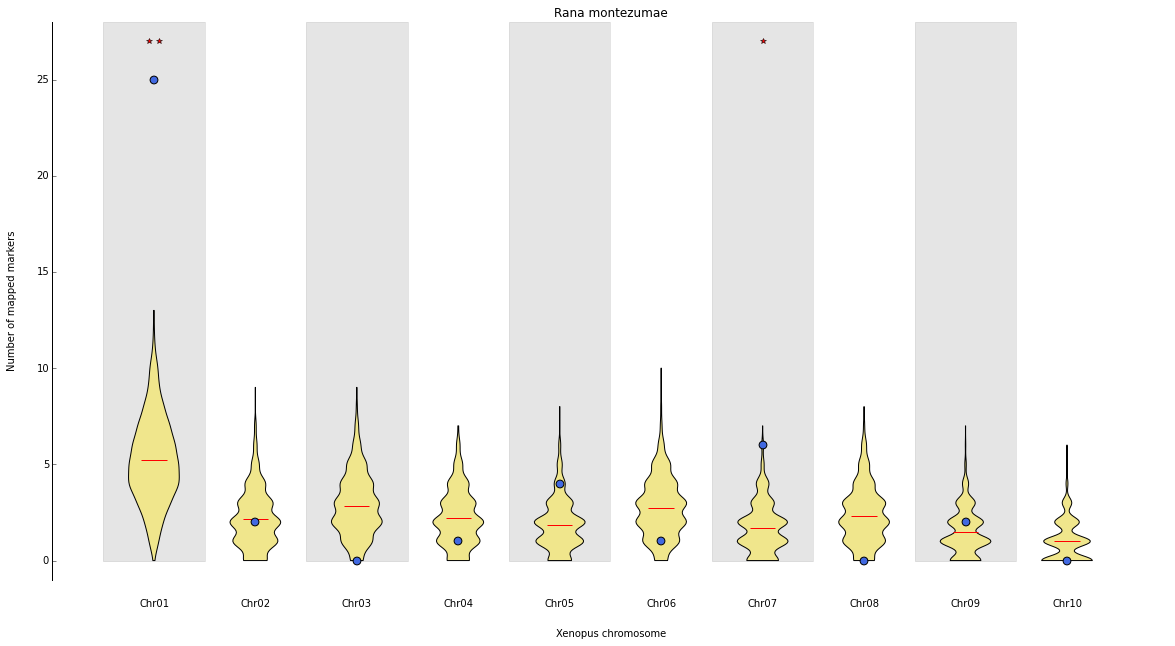


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Per_chromosome_mappings_test.svg


In [15]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/L_mont_all_XY.fa"
mySpecies = "Rana montezumae"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its = 1000, Species= mySpecies, Threads=7, Eval=1e-30)



### Rana montezumae all ZW

Got 1912 sex-linked tag IDs

Got 223805 catalog tag IDs

Removed 1912 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 9
Number of unique alingments kept: 20

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 11
Number of unique alingments kept: 13

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 10
Number of unique alingments kept: 22

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/Random_tags//random_sample_10

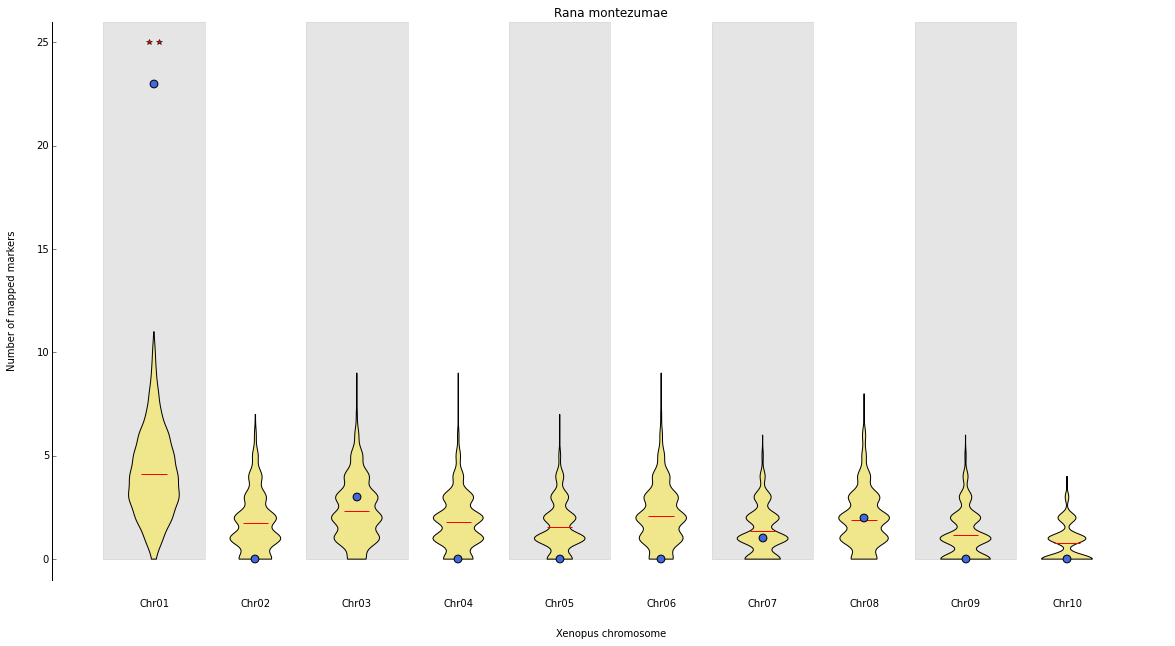


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/Per_chromosome_mappings_test.svg


In [16]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/ZW_mappings/L_mont_all_ZW.fa"
mySpecies = "Rana montezumae"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its = 1000, Species= mySpecies, Threads=7, Eval=1e-30)


### Rana pipiens (West)

Got 42 sex-linked tag IDs

Got 410175 catalog tag IDs

Removed 42 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_0.fasta (1 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_1.fasta (2 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_10.fasta (3 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_100.fasta (4 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_101.fasta (5 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//random_sample_102.fasta (6 of 1000)


Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags//r

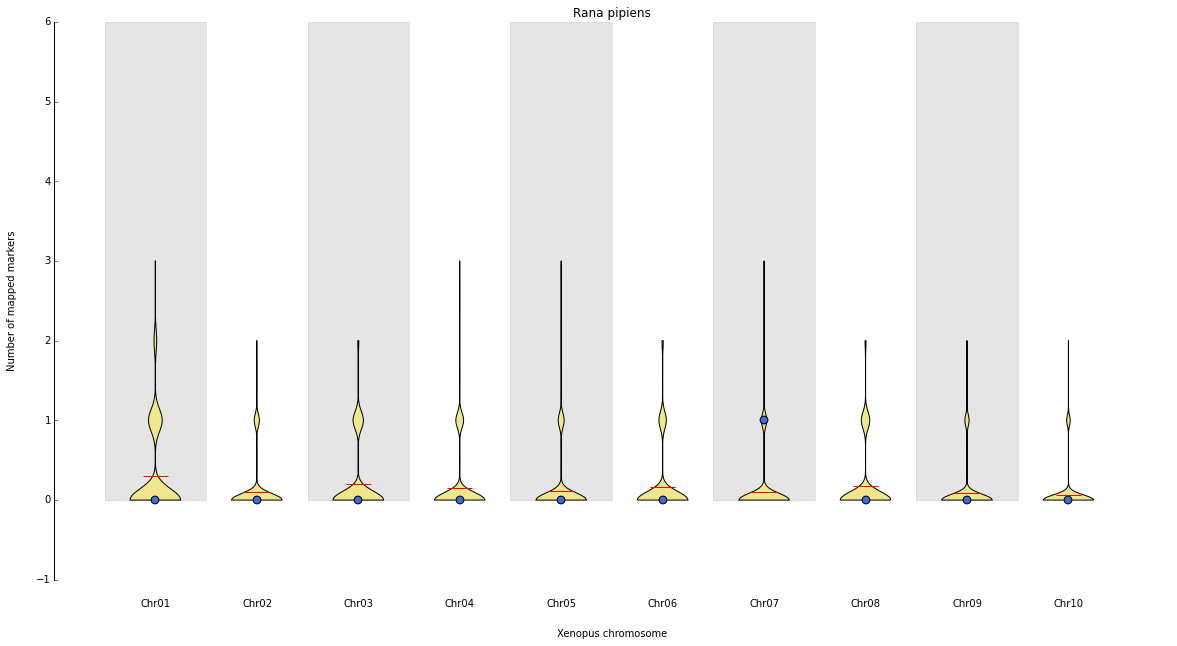


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Per_chromosome_mappings_test.svg


In [155]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Lpipiens/Lpip_all_stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/L_pipiens_west.fa"
mySpecies = "Rana pipiens"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana tarahumarae

Got 87 sex-linked tag IDs

Got 2625374 catalog tag IDs

Removed 87 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 0

Blasting /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 1

Blasting /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 1
Number of unique alingments kept: 1

Blasting /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 1
Number of unique alingments kept: 2

Blasting /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags//random_sam

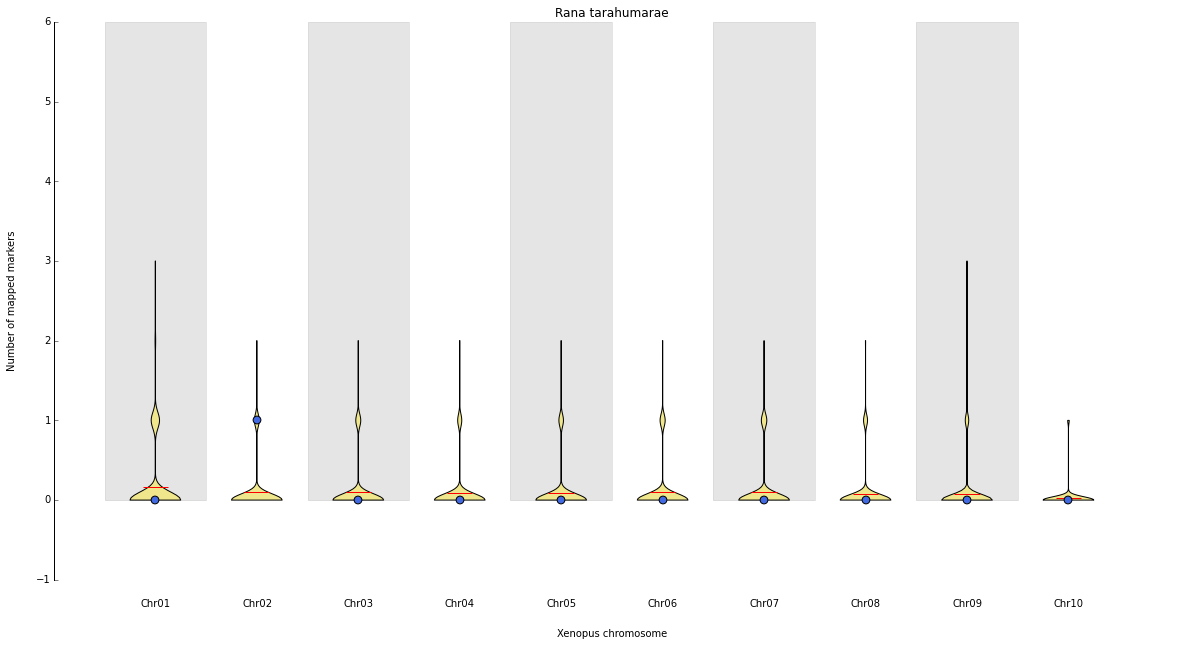


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Per_chromosome_mappings_test.svg


In [40]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Putative_XYlinked_makers.fa"
mySpecies = "Rana tarahumarae"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Pelophylax perezi

Got 200 sex-linked tag IDs

Got 296580 catalog tag IDs

Removed 200 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random_sample_0.fasta (1 of 1000)


Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random_sample_1.fasta (2 of 1000)


Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random_sample_10.fasta (3 of 1000)


Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random_sample_100.fasta (4 of 1000)


Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random_sample_101.fasta (5 of 1000)


Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags//random

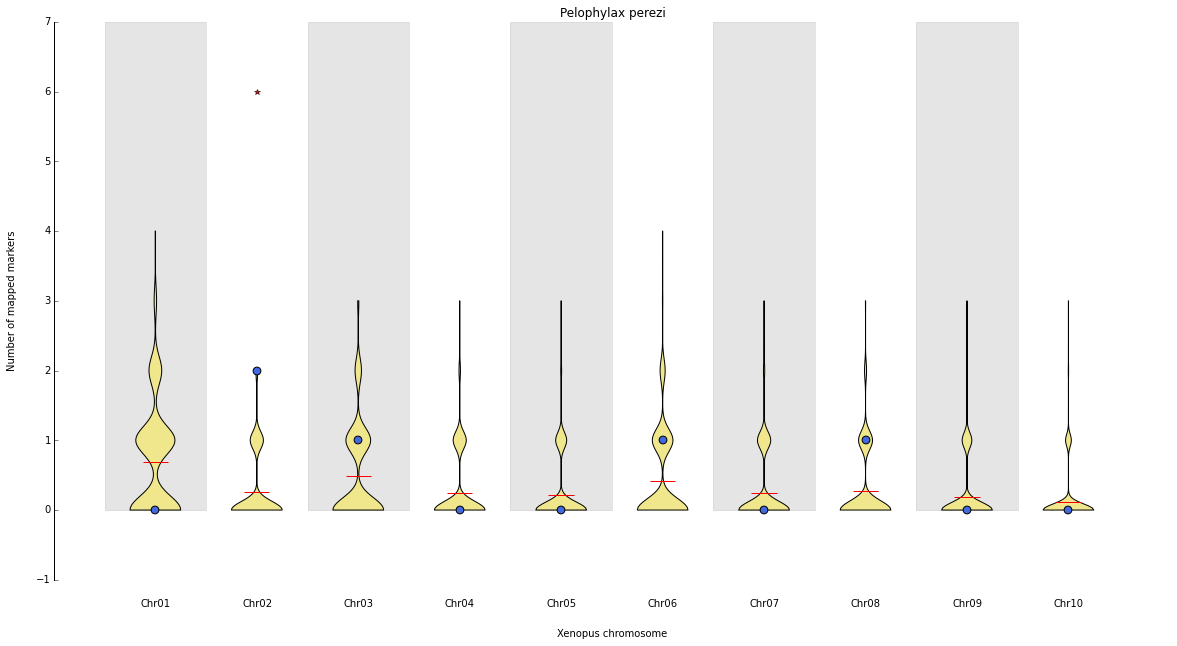


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Per_chromosome_mappings_test.svg


In [156]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Pperezi/Sex_linked_markers/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/P_perezi.fa"
mySpecies = "Pelophylax perezi"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its = 1000, Species= mySpecies, Threads=7, Eval=1e-20)


## Rana arvalis

In [17]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rarvalis_NEW/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/R_arvalis.fa"
mySpecies = "Rana arvalis"

Got 314 sex-linked tag IDs

Got 271191 catalog tag IDs

Removed 314 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 21
Number of unique alingments kept: 25

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 11
Number of unique alingments kept: 19

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 18
Number of unique alingments kept: 18

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 16
Numb

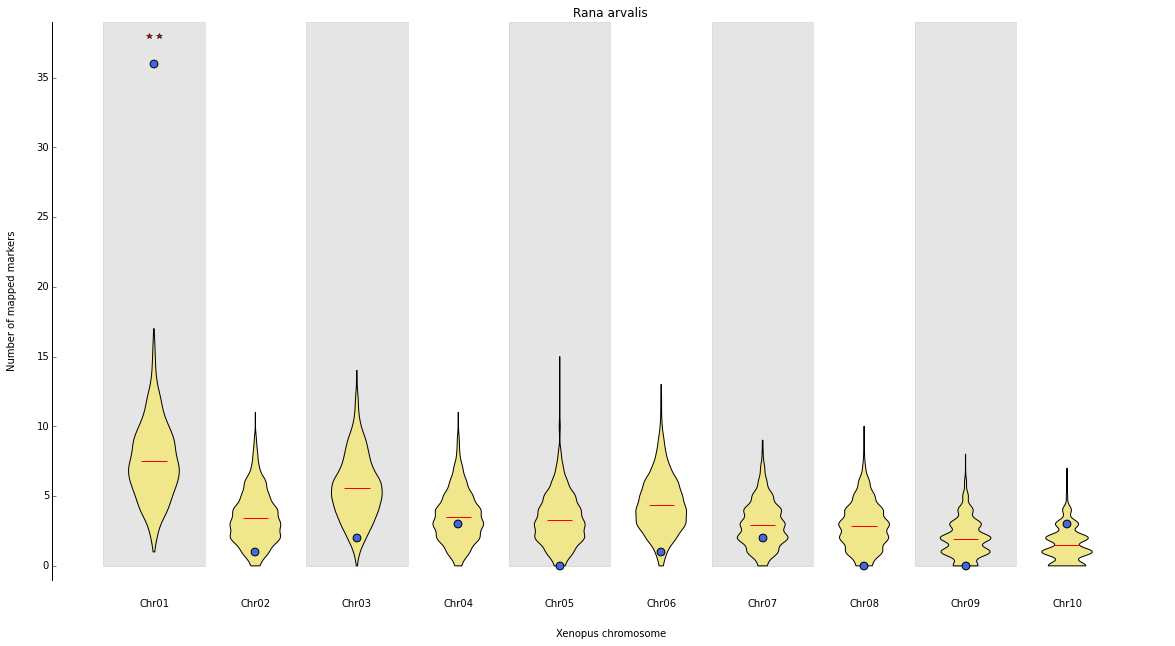


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Per_chromosome_mappings_test.svg


In [18]:
SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## R. dalmatina

Got 186 sex-linked tag IDs

Got 122228 catalog tag IDs

Removed 186 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 17

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 18

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 9
Number of unique alingments kept: 11

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 8
Number of unique alingments kept: 12

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_101.fasta (5 of 1000)

Num

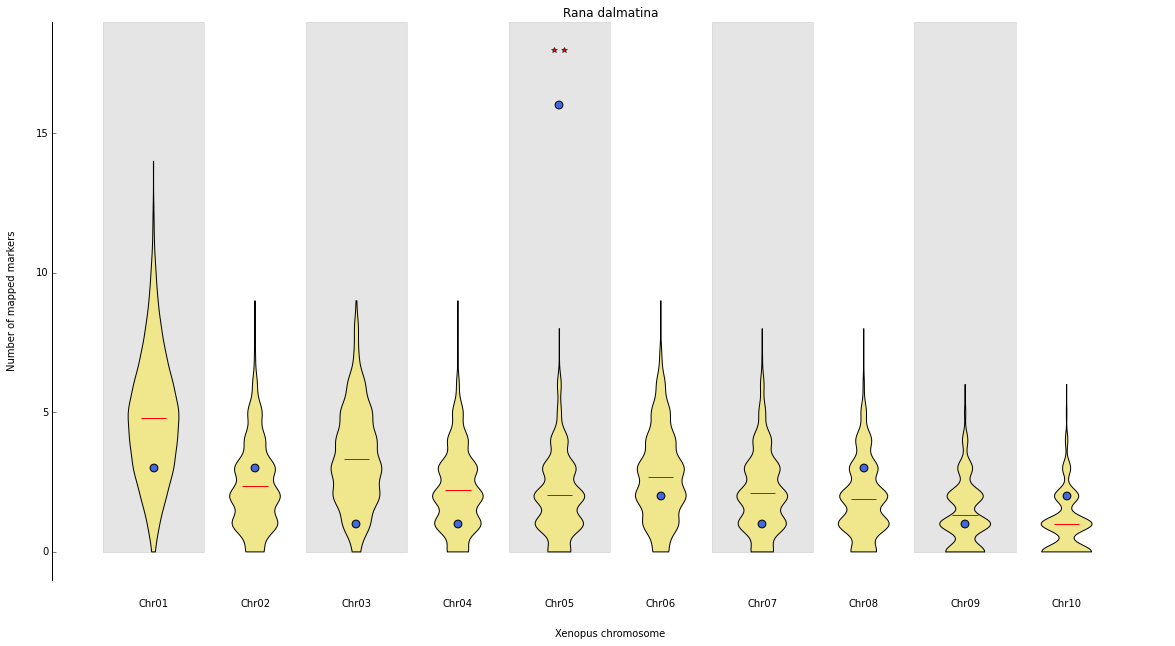


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Per_chromosome_mappings_test.svg


In [31]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rdalmatina/Populations_final/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/R_dalmatina.fa"
mySpecies = "Rana dalmatina"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana iberica Asturias populations

Got 490 sex-linked tag IDs

Got 385774 catalog tag IDs

Removed 490 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 15
Number of unique alingments kept: 41

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 18
Number of unique alingments kept: 31

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 19
Number of unique alingments kept: 29

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 19
Number of unique alingments kept: 36

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_101.fas

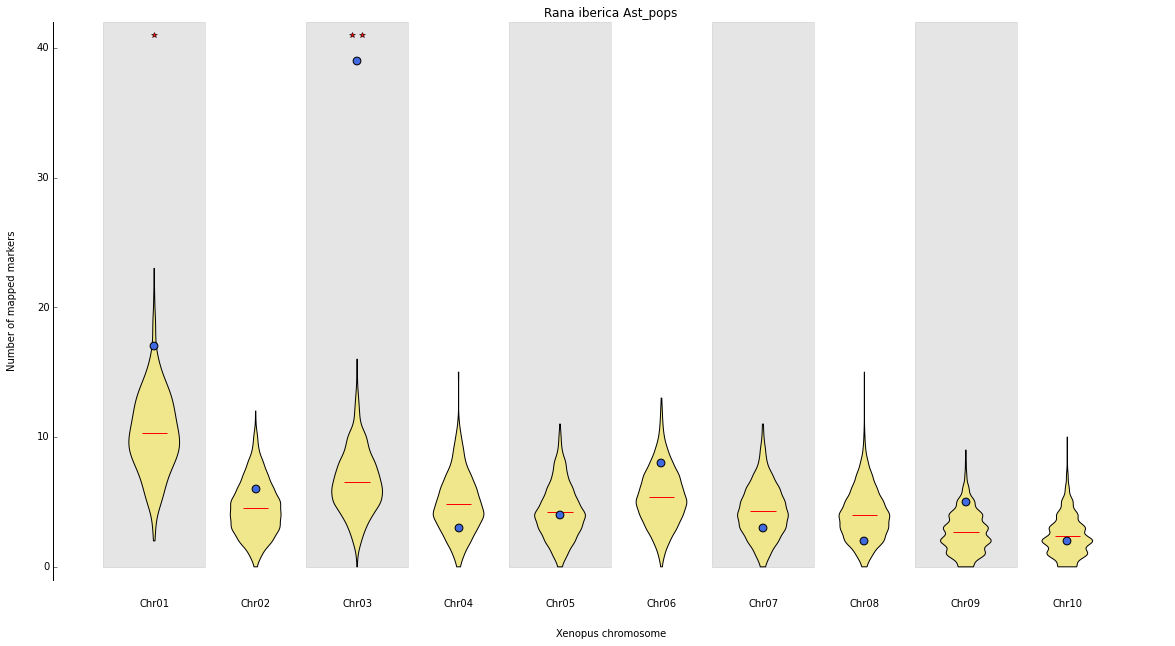


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Per_chromosome_mappings_test.svg


In [33]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/R_iberica_pops_SL_markers.fa"
mySpecies = "Rana iberica Ast_pops"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana iberica Asturias family

Got 483 sex-linked tag IDs

Got 385774 catalog tag IDs

Removed 483 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 18
Number of unique alingments kept: 25

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 18
Number of unique alingments kept: 34

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 21
Number of unique alingments kept: 24

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 18
Number of unique alingments kept: 20

Blasting /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags//random_sample_101.fas

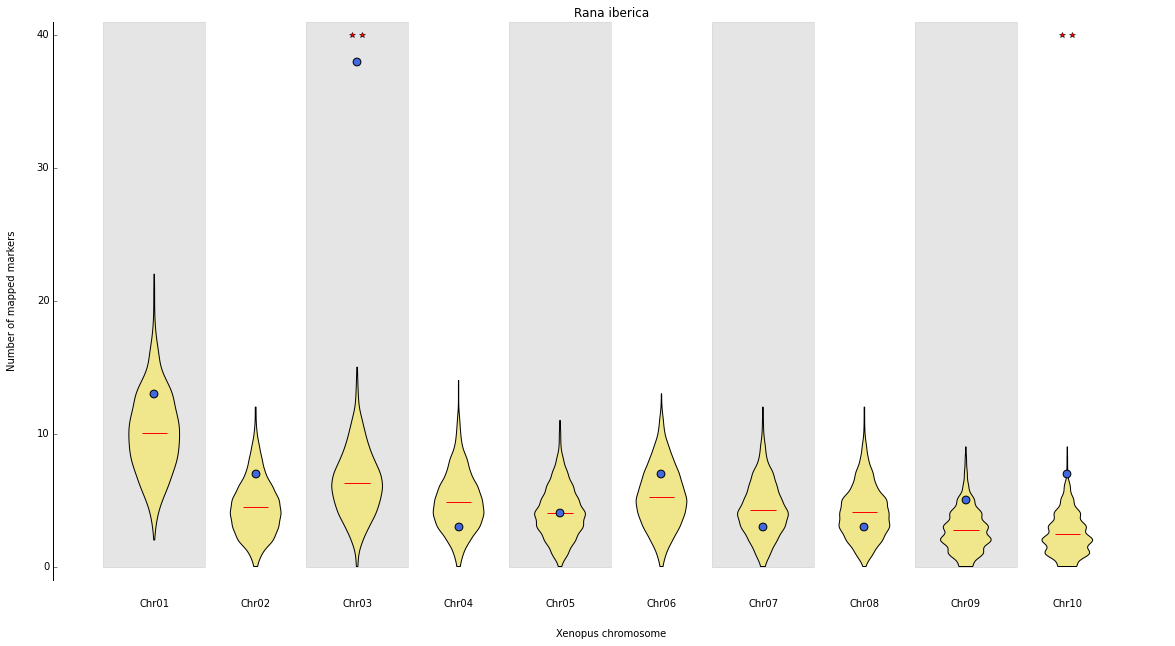


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Per_chromosome_mappings_test.svg


In [23]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/R_iberica_fam_SL_markers.fa"
mySpecies = "Rana iberica"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana italica - family XY

In [ ]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Putative_XYlinked_makers.fa"
mySpecies = "Rana italica"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana italica - family ZW

In [ ]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Putative_ZWlinked_makers.fa"
mySpecies = "Rana italica"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

### Rana japonica 't' population

Got 710 sex-linked tag IDs

Got 286892 catalog tag IDs

Removed 710 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 19
Number of unique alingments kept: 27

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 11
Number of unique alingments kept: 27

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 11
Number of unique alingments kept: 27

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 21


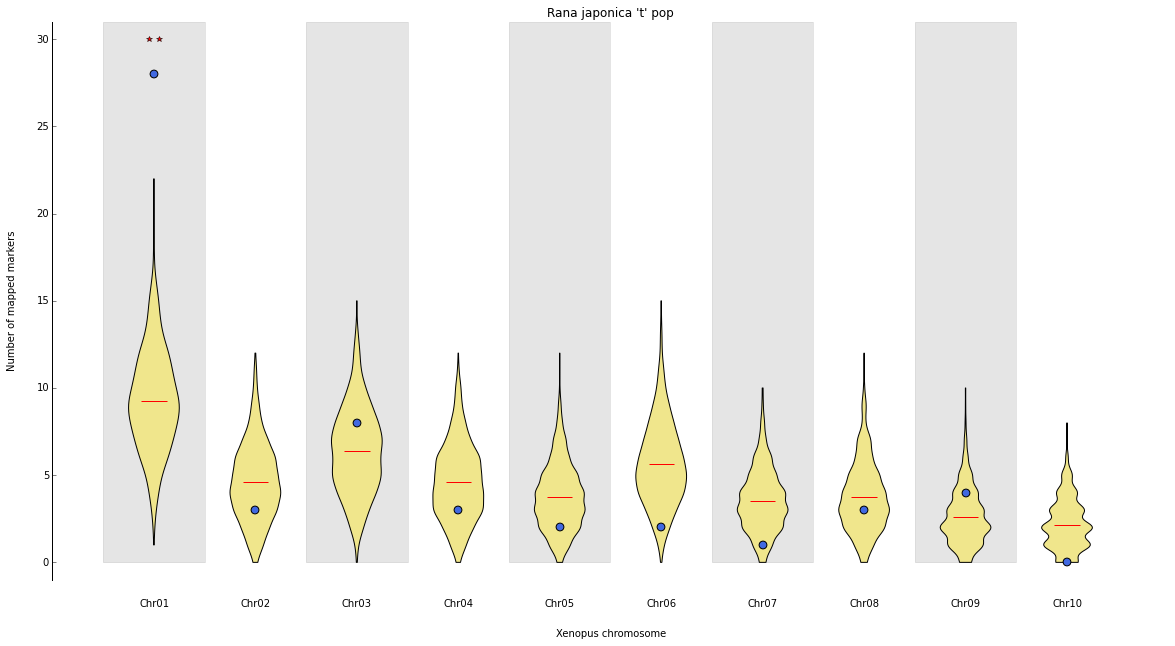


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Per_chromosome_mappings_test.svg


In [34]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rjaponica/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/R_jap_pop_t.fa"
mySpecies = "Rana japonica 't' pop"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

### Rana kukinoris Nanping

Got 350 sex-linked tag IDs

Got 250358 catalog tag IDs

Removed 350 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 15
Number of unique alingments kept: 10

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 8
Number of unique alingments kept: 15

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 16

Blasting /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 1

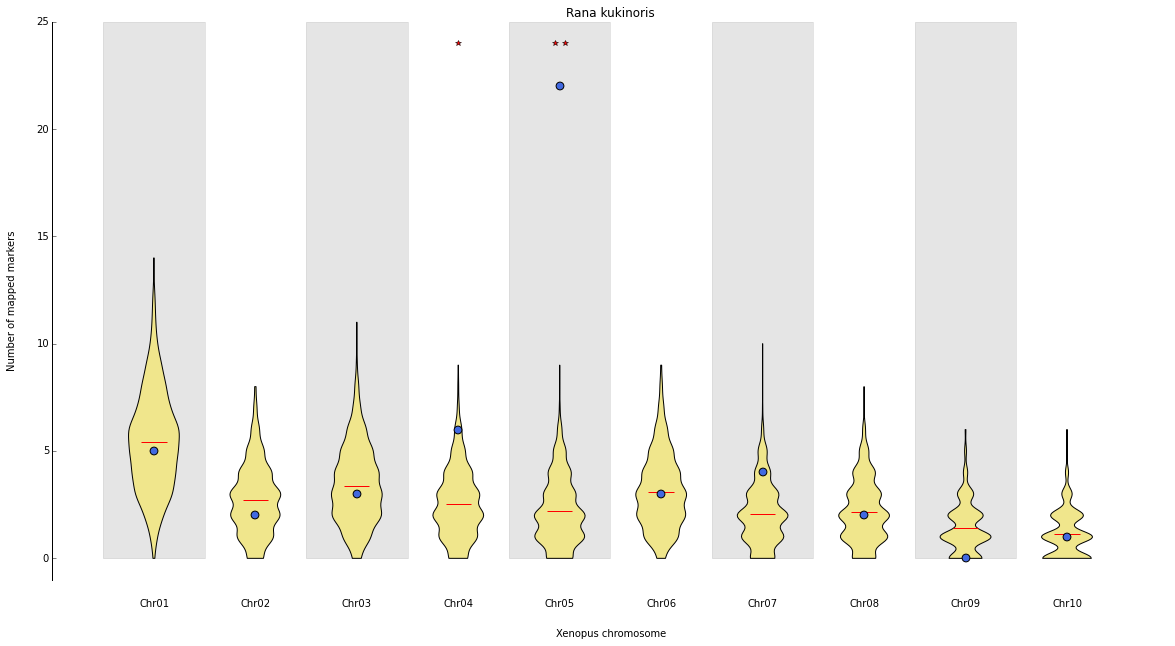


All done, figure saved as svg here: /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Per_chromosome_mappings_test.svg


In [30]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rkukinoris/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/R_kukinoris_Nanping.fa"
mySpecies = "Rana kukinoris"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

### Rana kukinoris Muyu - Banqiao

Got 380 sex-linked tag IDs

Got 250358 catalog tag IDs

Removed 380 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 13
Number of unique alingments kept: 14

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 14
Number of unique alingments kept: 17

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 10
Number of unique alingments kept: 23

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 7
Number of unique alingments kept: 11

Blasting /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Random_tags//random_sample_101.fasta (5 of 1000)



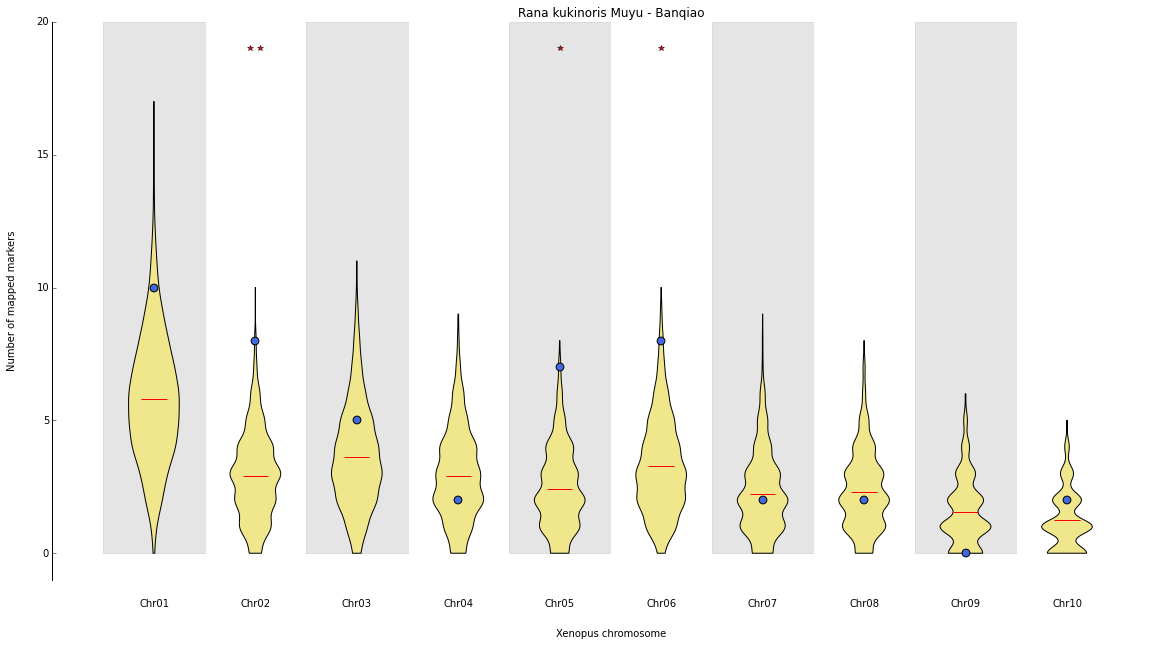


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Final_sex_linked_markers/Per_chromosome_mappings_test.svg


In [36]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rkukinoris/Stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/R kukinoris Muyu_Banqiao.fa"
mySpecies = "Rana kukinoris Muyu - Banqiao"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000, Species= mySpecies, Threads=7)

## Rana latastei

Got 94 sex-linked tag IDs

Got 252793 catalog tag IDs

Removed 94 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 11

Blasting /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 5
Number of unique alingments kept: 10

Blasting /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 6
Number of unique alingments kept: 14

Blasting /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 7
Number of unique alingments kept: 9

Blasting /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random

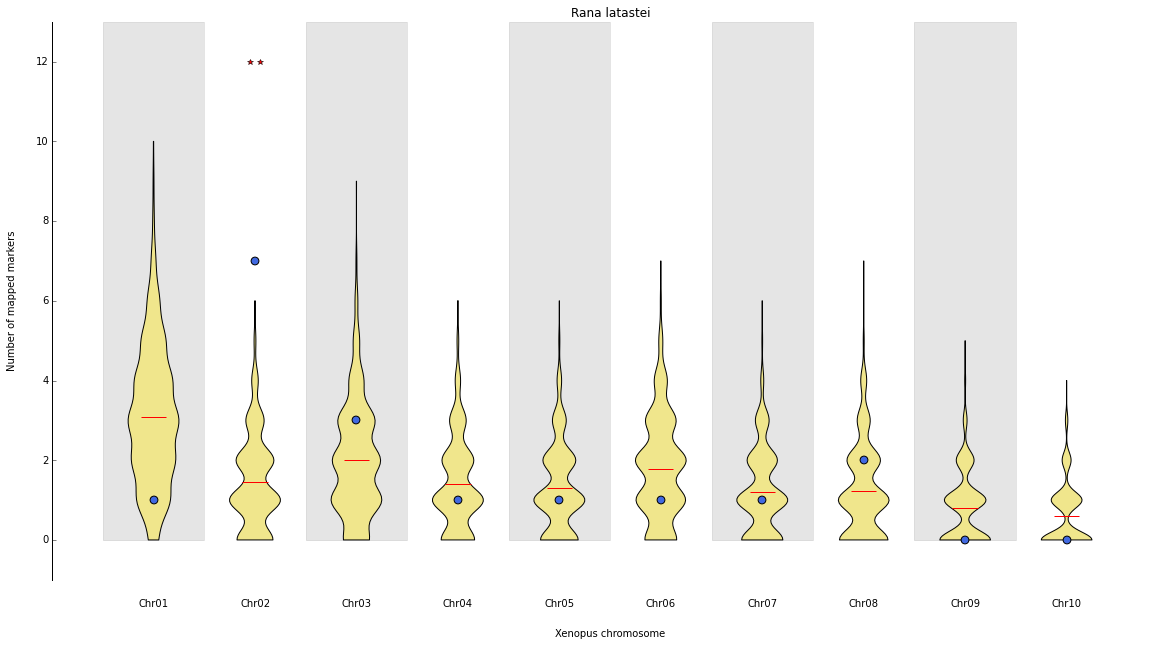


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Per_chromosome_mappings_test.svg


In [46]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Putative_XYlinked_makers.fa"
mySpecies = "Rana latastei"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its=1000,Eval=1e-15, Species= mySpecies, Threads=7)

### Rana pipiens West

In [152]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Lpipiens/Lpip_all_stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_pipiens/L_pipiens_HOR_SWE.fa"
mySpecies = "Rana pipiens"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its = 1000, Species= mySpecies, Threads=7, Eval=1e-20)


NameError: name 'Null_mapper' is not defined

### Rana ornativentris "o" population - heterozygosity method only

Got 203 sex-linked tag IDs

Got 410175 catalog tag IDs

Removed 203 tags from catalog tags

Making 1000 fasta files

Doing 1000 Random mapping iterations

Blasting /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags//random_sample_0.fasta (1 of 1000)

Number of multi-alingments kept: 3
Number of unique alingments kept: 6

Blasting /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags//random_sample_1.fasta (2 of 1000)

Number of multi-alingments kept: 5
Number of unique alingments kept: 4

Blasting /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags//random_sample_10.fasta (3 of 1000)

Number of multi-alingments kept: 2
Number of unique alingments kept: 5

Blasting /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags//random_sample_100.fasta (4 of 1000)

Number of multi-alingments kept: 0
Number of unique alingments kept: 2

Blasting /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags//random_sample_101.fasta (5 of 1000)

Number of multi-alingm

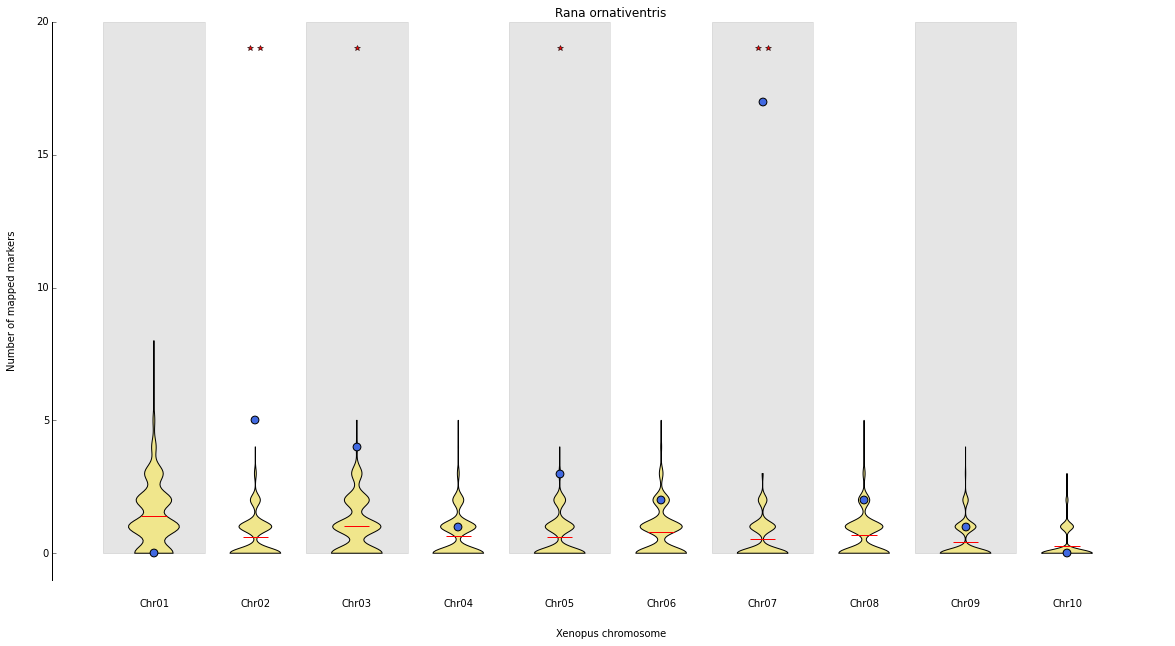


All done, figure saved as svg here: /home/djeffrie/Data/RADseq/Rornativentris/Stacks/Per_chromosome_mappings_test.svg


In [35]:
myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"
mycatalog_path = "/home/djeffrie/Data/RADseq/Lpipiens/Lpip_all_stacks/batch_1.catalog.tags.tsv.gz"
mysex_linked_markers_path = "/home/djeffrie/Data/RADseq/Rornativentris/Stacks/Putative_ZWlinked_makers_o_pop_het_only.fa"
mySpecies = "Rana ornativentris"

SL_mappings, Null_mappings = Null_mapper(mysex_linked_markers_path, mycatalog_path, myGenome_fasta, myGenome_db, N_its = 1000, Species= mySpecies, Threads=7, Eval=1e-20)


### In the above analyses I have overlooked one thing, which is that there are several Xen scaffolds that have multiple Rtemp LGs. . . . 

So instead of plotting these mapping results by Xenopus chromosome, I should be doing it by Rtemp linkage group. . . . 

This is a pain, but I should be able to find which mappings correspond to which LG without doing the whole mapping again . . . 

### First

I need to work out which linkage groups correspond to which Xenopus chromosomes . . . using the mapping summary from the male maps.

In [2]:
mapping_summary = open("/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/All_fams_MALE_LG_mapping_summary.tsv", 'r')

scaff_dict = {}

for line in mapping_summary.readlines()[1:]:
    
    Fam = line.split()[0]
    Rtemp_LG = line.split()[1]
    Rtemp_scaff = line.split()[3]
    Xen_chrom = line.split()[6]
    
    if not Rtemp_scaff == "-":
        if Xen_chrom not in scaff_dict:
            scaff_dict[Xen_chrom] = {}
        if Fam not in scaff_dict[Xen_chrom]:
            scaff_dict[Xen_chrom][Fam] = {}
        if not Fam in scaff_dict[Xen_chrom]:
            scaff_dict[Xen_chrom][Fam][Rtemp_LG] = []
        if not Rtemp_LG in scaff_dict[Xen_chrom][Fam]:
            scaff_dict[Xen_chrom][Fam][Rtemp_LG] = []
        scaff_dict[Xen_chrom][Fam][Rtemp_LG].append(Rtemp_scaff)



Now try to collapse these families down into just a set of scaffolds for each chromosome. 

In [3]:
import operator

collapsed_scaffs = {}

for Xen_chrom in scaff_dict:
    
    if Xen_chrom not in collapsed_scaffs:
        collapsed_scaffs[Xen_chrom] = []

    if not Xen_chrom in ["Chr04", "Chr07", "Chr08"]:
    
        for family in scaff_dict[Xen_chrom]:
            
            for i in scaff_dict[Xen_chrom][family]:
                for j in scaff_dict[Xen_chrom][family][i]:
                    if j not in collapsed_scaffs[Xen_chrom]:
                        collapsed_scaffs[Xen_chrom].append(j)
                        
    elif Xen_chrom in ["Chr04", "Chr07", "Chr08"]:  ## if a family has two LGs for a chromosome, merge it with the other LGs of the most similar size from the other families
            
        collapsed_scaffs[Xen_chrom] = {}
        collapsed_scaffs[Xen_chrom]["A"] = []
        collapsed_scaffs[Xen_chrom]["B"] = []
            
        for family in scaff_dict[Xen_chrom]:
            
            #print family, Xen_chrom, scaff_dict[Xen_chrom][family].keys()
            
            if len(scaff_dict[Xen_chrom][family]) == 2:
                
                LG_len_dict = {}

                for LG in scaff_dict[Xen_chrom][family]:
                    LG_len_dict[LG] = len(scaff_dict[Xen_chrom][family][LG])

                big_LG = max(LG_len_dict.iteritems(), key=operator.itemgetter(1))[0]
                small_LG = min(LG_len_dict.iteritems(), key=operator.itemgetter(1))[0]

                for j in scaff_dict[Xen_chrom][family][big_LG]:
                    if j not in collapsed_scaffs[Xen_chrom]["A"]:
                        collapsed_scaffs[Xen_chrom]["A"].append(j)

                for j in scaff_dict[Xen_chrom][family][small_LG]:
                    if j not in collapsed_scaffs[Xen_chrom]["B"]:
                        collapsed_scaffs[Xen_chrom]["B"].append(j)
            else:
                for i in scaff_dict[Xen_chrom][family]:
                    for j in scaff_dict[Xen_chrom][family][i]:
                        if j not in collapsed_scaffs[Xen_chrom]["A"]:
                            collapsed_scaffs[Xen_chrom]["A"].append(j)
                            

                
            
            
for chrom in collapsed_scaffs:
    if len(collapsed_scaffs[chrom]) == 2:
        for lg in collapsed_scaffs[chrom]:
            print chrom, lg, len(collapsed_scaffs[chrom][lg])
    else:
        print chrom, len(collapsed_scaffs[chrom])
    
    

Chr10 272
Chr08 A 334
Chr08 B 205
Chr09 367
Chr04 A 358
Chr04 B 283
Chr05 758
Chr06 1012
Chr07 A 422
Chr07 B 332
Chr01 1617
Chr02 866
Chr03 920


Ok, so I now know which scaffolds belong to which Rtemp linkage group, now need to get the filtered hits from a blast out files. . . 

In [104]:
blast_hits = []
for i in filtered_blast_outs:
    hit_scaff = filtered_blast_outs[i]["Ref_hit_id"].split("_")[3].split()[0]
    blast_hits.append(hit_scaff)

In [108]:
test = Get_Rtemp_LG_hits(filtered_blast_outs)

In [4]:
## define a function to get the blast hits from the filtered blast outputs and separate them by Rtemp linkage group:

def Get_Rtemp_LG_hits(blast_outs_filtered):
    
    """
    Takes the dictionary of filtered blast hits from BlastparseExtra function
    """

    Rtemp_chroms = {}

    Rtemp_chroms["Chr01"] = 0
    Rtemp_chroms["Chr02"] = 0
    Rtemp_chroms["Chr03"] = 0
    Rtemp_chroms["Chr04_A"] = 0
    Rtemp_chroms["Chr04_B"] = 0
    Rtemp_chroms["Chr05"] = 0
    Rtemp_chroms["Chr06"] = 0
    Rtemp_chroms["Chr07_A"] = 0
    Rtemp_chroms["Chr07_B"] = 0
    Rtemp_chroms["Chr08_A"] = 0
    Rtemp_chroms["Chr08_B"] = 0
    Rtemp_chroms["Chr09"] = 0
    Rtemp_chroms["Chr10"] = 0

    blast_hits = []
    for i in blast_outs_filtered:
        hit_scaff = blast_outs_filtered[i]["Ref_hit_id"].split("_")[3].split()[0]
        blast_hits.append(hit_scaff)

    for Xen_chrom in collapsed_scaffs:
        if len(collapsed_scaffs[Xen_chrom]) == 2:
            for LG in collapsed_scaffs[Xen_chrom]:
                for scaff in collapsed_scaffs[Xen_chrom][LG]:
                    if scaff in blast_hits:
                        Rtemp_chrom = "%s_%s" % (Xen_chrom, LG)
                        if Rtemp_chrom in Rtemp_chroms:
                            Rtemp_chroms[Rtemp_chrom] += 1

                        #print Xen_chrom, LG, scaff
        else:
            for scaff in collapsed_scaffs[Xen_chrom]:
                if scaff in blast_hits:
                    if Xen_chrom in Rtemp_chroms:
                        Rtemp_chroms[Xen_chrom] += 1
                    #print Xen_chrom, scaff

    return Rtemp_chroms

Ok, so now I will define a set of functions to loop over all of the xml files in a parrallelised way and get the mappings per chromosome.

In [60]:
def Get_blast_paths(input_dir):
    import os
    
    ## get the paths of the blast out files in the directory

    blast_outfile_paths = []

    for root, dirs, files in os.walk(input_dir):
        for fil in files:
            if "blastn.xml" in fil:
                blast_outfile_paths.append("%s/%s" % (root, fil))
                
    return blast_outfile_paths

In [135]:

infile = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags/random_sample_0_blastn.xml.gz"

filtered_blast_outs = MISC.BlastParseExtra(infile, " " , 1e-5, 1e-20, 1000 , 0, 1)

Number of multi-alingments kept: 26
Number of unique alingments kept: 53


In [162]:
def para_blastparse(in_file):  ## parrallelised function so it only needs to take one argument - the path
    
    filtered_blast_outs = MISC.BlastParseExtra(in_file, " " , 1e-5, 1e-15, 1000 , 0, 0)
    
    return filtered_blast_outs

In [63]:
## define a function to get the blast hits from the filtered blast outputs and separate them by Rtemp linkage group:

def Get_Rtemp_LG_hits(blast_outs_filtered):
    
    """
    Takes the dictionary of filtered blast hits from BlastparseExtra function
    """

    Rtemp_chroms = {}

    Rtemp_chroms["Chr01"] = 0
    Rtemp_chroms["Chr02"] = 0
    Rtemp_chroms["Chr03"] = 0
    Rtemp_chroms["Chr04_A"] = 0
    Rtemp_chroms["Chr04_B"] = 0
    Rtemp_chroms["Chr05"] = 0
    Rtemp_chroms["Chr06"] = 0
    Rtemp_chroms["Chr07_A"] = 0
    Rtemp_chroms["Chr07_B"] = 0
    Rtemp_chroms["Chr08_A"] = 0
    Rtemp_chroms["Chr08_B"] = 0
    Rtemp_chroms["Chr09"] = 0
    Rtemp_chroms["Chr10"] = 0

    blast_hits = []
    for i in blast_outs_filtered:
        hit_scaff = blast_outs_filtered[i]["Ref_hit_id"].split("_")[3].split()[0]
        blast_hits.append(hit_scaff)

    for Xen_chrom in collapsed_scaffs:
        if len(collapsed_scaffs[Xen_chrom]) == 2:
            for LG in collapsed_scaffs[Xen_chrom]:
                for scaff in collapsed_scaffs[Xen_chrom][LG]:
                    if scaff in blast_hits:
                        Rtemp_chrom = "%s_%s" % (Xen_chrom, LG)
                        if Rtemp_chrom in Rtemp_chroms:
                            Rtemp_chroms[Rtemp_chrom] += 1

                        #print Xen_chrom, LG, scaff
        else:
            for scaff in collapsed_scaffs[Xen_chrom]:
                if scaff in blast_hits:
                    if Xen_chrom in Rtemp_chroms:
                        Rtemp_chroms[Xen_chrom] += 1
                    #print Xen_chrom, scaff

    return Rtemp_chroms

In [66]:
def sort_mappings(list_of_filtered_hit_dictionaries):
    
    ## set up the dictionary to catch all results

    Rtemp_chroms_totals = {}
    Rtemp_chroms_totals["Chr01"] = []
    Rtemp_chroms_totals["Chr02"] = []
    Rtemp_chroms_totals["Chr03"] = []
    Rtemp_chroms_totals["Chr04_A"] = []
    Rtemp_chroms_totals["Chr04_B"] = []
    Rtemp_chroms_totals["Chr05"] = []
    Rtemp_chroms_totals["Chr06"] = []
    Rtemp_chroms_totals["Chr07_A"] = []
    Rtemp_chroms_totals["Chr07_B"] = []
    Rtemp_chroms_totals["Chr08_A"] = []
    Rtemp_chroms_totals["Chr08_B"] = []
    Rtemp_chroms_totals["Chr09"] = []
    Rtemp_chroms_totals["Chr10"] = []
    
    
    for filtered_blast_outs in list_of_filtered_hit_dictionaries:
        
        per_LG_filtered_hits = Get_Rtemp_LG_hits(filtered_blast_outs) ## spearate hits by their Rtemp chromosome

        ## Now add these ordered hits to the totals dictionary

        for Rtemp_chrom in per_LG_filtered_hits:
            Rtemp_chroms_totals[Rtemp_chrom].append(per_LG_filtered_hits[Rtemp_chrom])
    
    return Rtemp_chroms_totals

In [218]:
def Real_SLM_mapper(SLM_mapping_path, Genome_db):
    
    from Bio.Blast.Applications import NcbiblastnCommandline
    import MISC_RAD_tools as MISC
    
    Threads = 6
        
    real_SLM_blast_out_path = "%s_REAL_SL_TAG_blastn_outs.xml" % SLM_mapping_path.rpartition(".")[0]
    
    blastn_cline = NcbiblastnCommandline(query=SLM_mapping_path, db=Genome_db, outfmt=5, out=real_SLM_blast_out_path, num_threads = Threads)
    stdout, stderr = blastn_cline()

    real_SLM_filtered_blast_outs = MISC.BlastParseExtra(real_SLM_blast_out_path, " " , 1e-5, 1e-20, 1000 , 0, 0)
    
    sorted_real_SLM_hits = Get_Rtemp_LG_hits(real_SLM_filtered_blast_outs)
    
    return sorted_real_SLM_hits
    

In [179]:
# And now then I just need to plot this as box plots

def Plot_mappings_per_chrom(Total_sorted_mappings, real_mappings, plot_output_path, Ylim = None):
    
    from matplotlib import pyplot as plt

    fig = plt.figure(figsize=(20,10), frameon = False, edgecolor = 'none')
    ax = plt.subplot(111)
    pos = 1
    col = "white"
    
    
    max_y = max([max(i) for i in Total_sorted_mappings.values()] + real_mappings.values()) + 3
    
    for i in sorted(Total_sorted_mappings.keys()):

        if col == "grey":
            col = "white"
        elif col == "white":
            col = "grey"
        
        ax.bar(left = pos-0.5, width = 1, height= max_y, color= col, edgecolor = col, bottom = 0, alpha = 0.2, zorder = 1)
        vio = ax.violinplot(Total_sorted_mappings[i], positions=[pos], showmeans = True, showextrema = False )
        
        for pc in vio['bodies']:
            pc.set_facecolor('khaki')
            pc.set_edgecolor('black')
            pc.set_zorder(2)    
            pc.set_alpha(1)
        
        ax.scatter(pos, real_mappings[i], s = 60, zorder = 3, c = "royalblue")
        
        if real_mappings[i] > np.percentile(Total_sorted_mappings[i], 99):
            ax.plot(pos-0.05, max([max(i) for i in Total_sorted_mappings.values()] + real_mappings.values()) + 2, "*r", zorder = 3)
            ax.plot(pos+0.05, max([max(i) for i in Total_sorted_mappings.values()] + real_mappings.values()) + 2, "*r", zorder = 3)
        elif real_mappings[i] > np.percentile(Total_sorted_mappings[i], 95):
            ax.plot(pos, max([max(i) for i in Total_sorted_mappings.values()] + real_mappings.values()) + 2, "*r", zorder = 3)
        
        pos += 1

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left spines
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(0, 14)
    if Ylim == None:
        ax.set_ylim(-1, max([max(i) for i in Total_sorted_mappings.values()] + real_mappings.values()) + 3)
    else:
        ax.set_ylim(Ylim)
    ax.set_xticks(range(1,14))
    ax.set_xticklabels(sorted(Total_sorted_mappings.keys()))
    ax.set_xlabel("Xenopus chromosome", labelpad=20)
    ax.set_ylabel("Number of mapped markers",labelpad=20)
    ax.get_xaxis().set_tick_params(which='both', direction='out', pad = 15, bottom = 'off', top = 'off')


    plt.savefig(plot_output_path)
    
    plt.show()

### Ok, so that is it, just go through this for every species now

## L. chiricahuensis

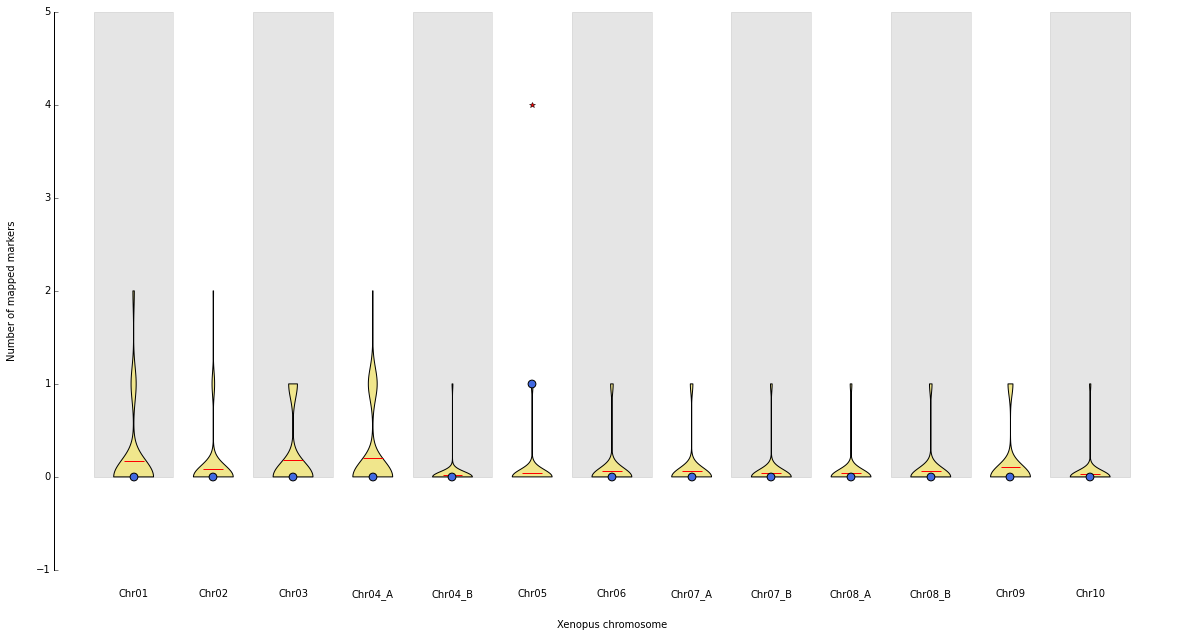

In [132]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_chiricahuensis/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_chiricahuensis.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

### Rana montezumae all XY

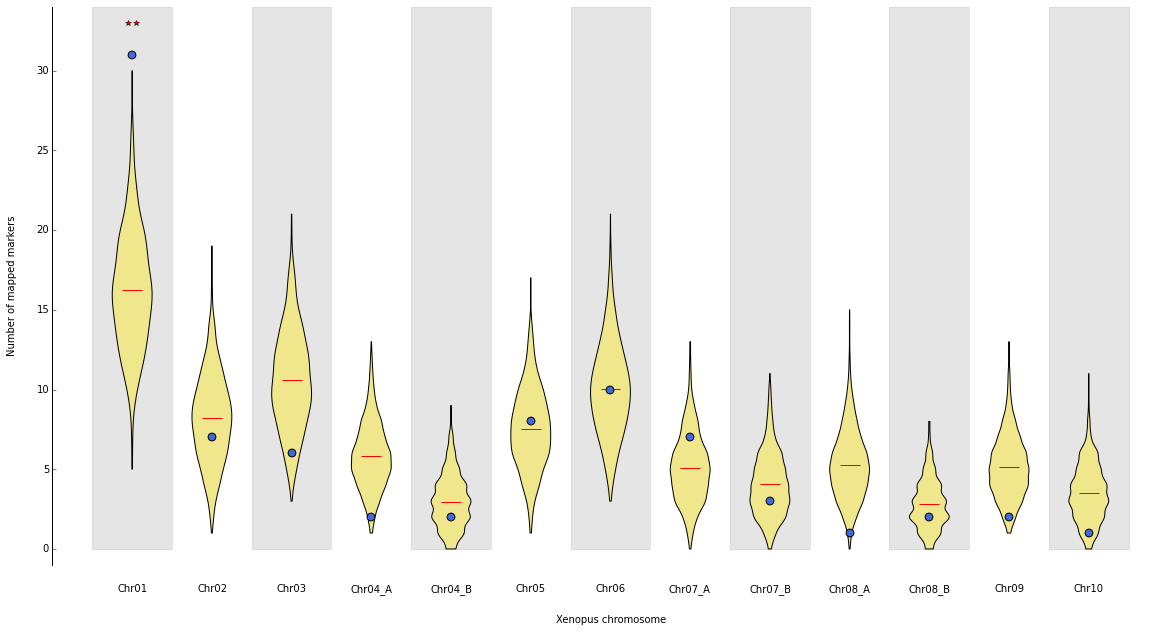

In [151]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/L_montezumae/XY_mappings/L_mont_all_XY.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## R. arvalis

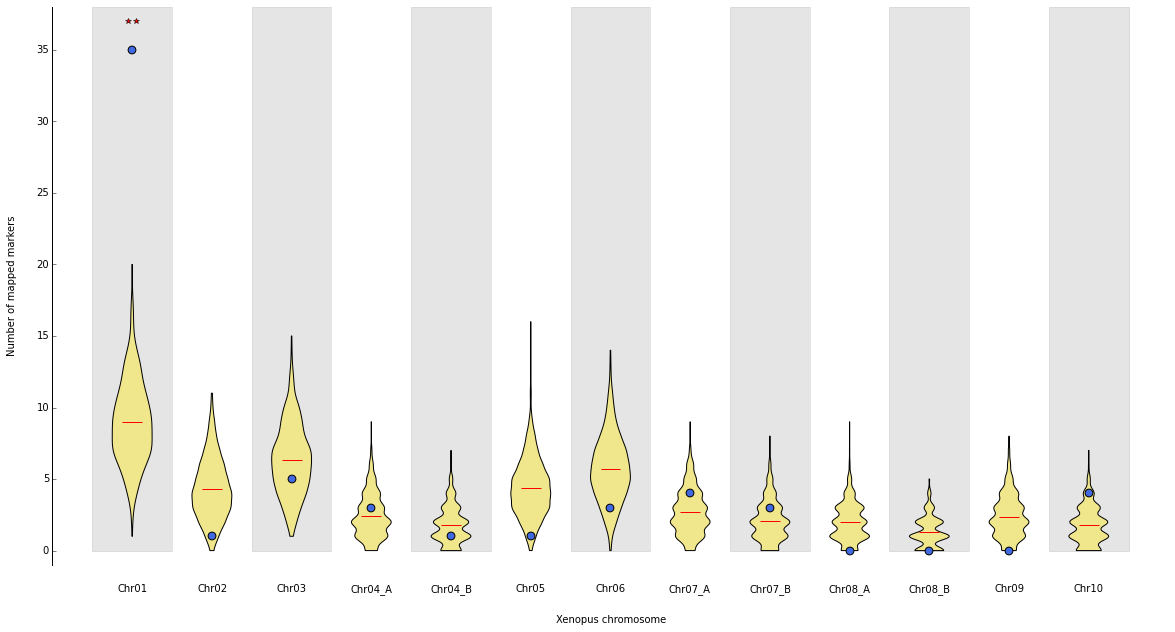

In [164]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_arvalis/R_arvalis.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## R. dalmatina

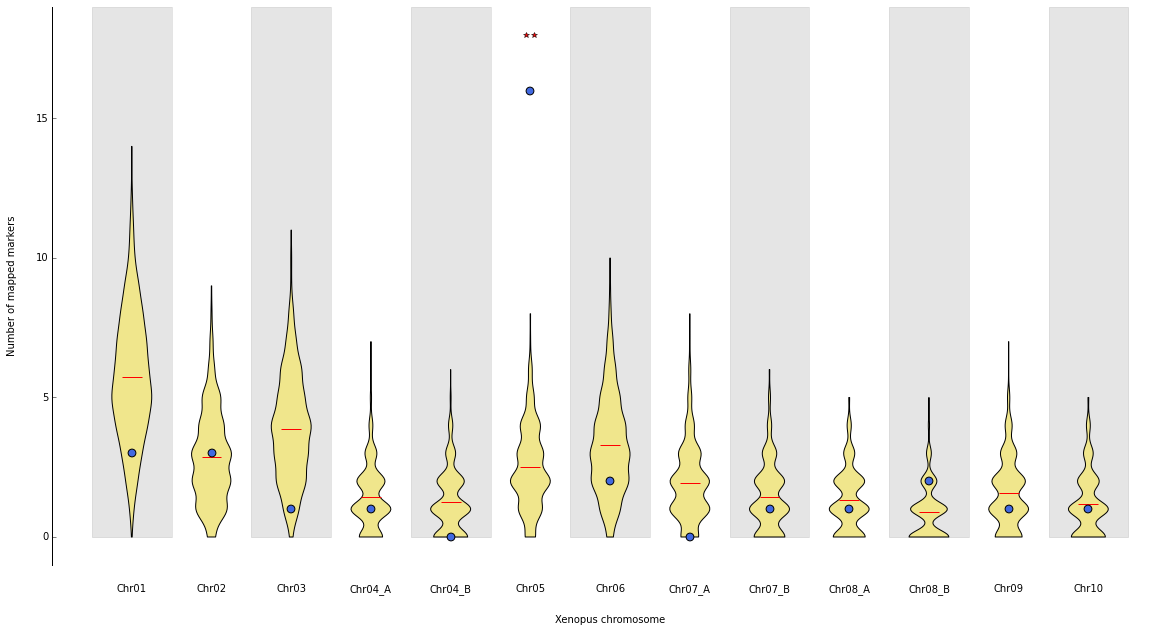

In [143]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_dalmatina/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/R_dalmatina.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## Rana iberica Asturias populations

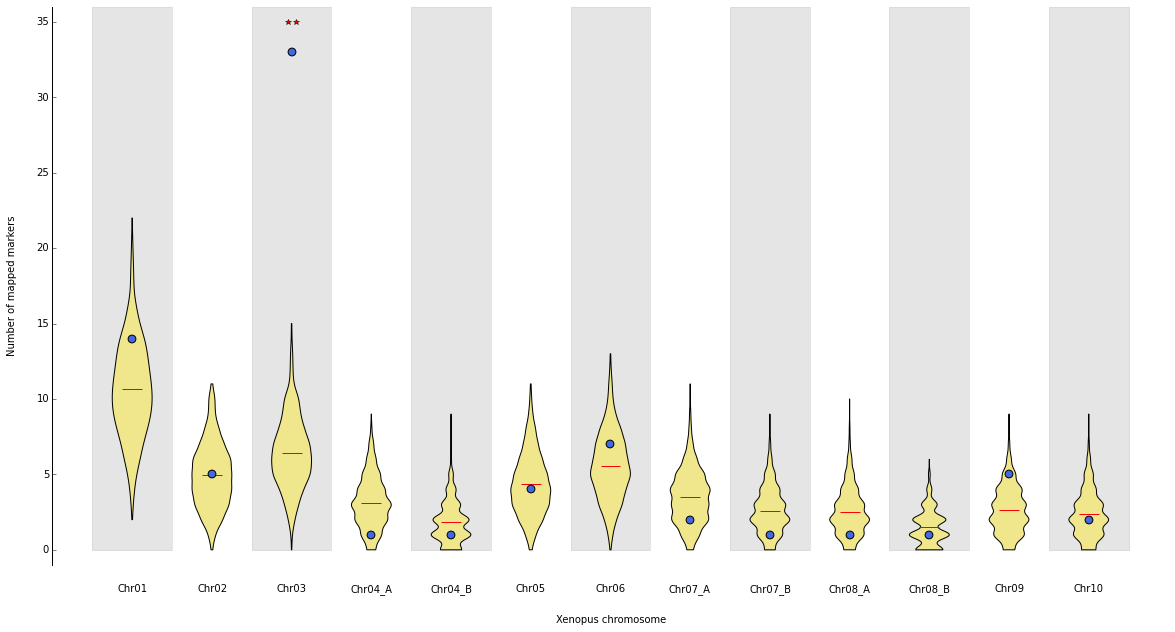

In [145]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/R_iberica_pops_SL_markers.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## Rana iberica Asturias family

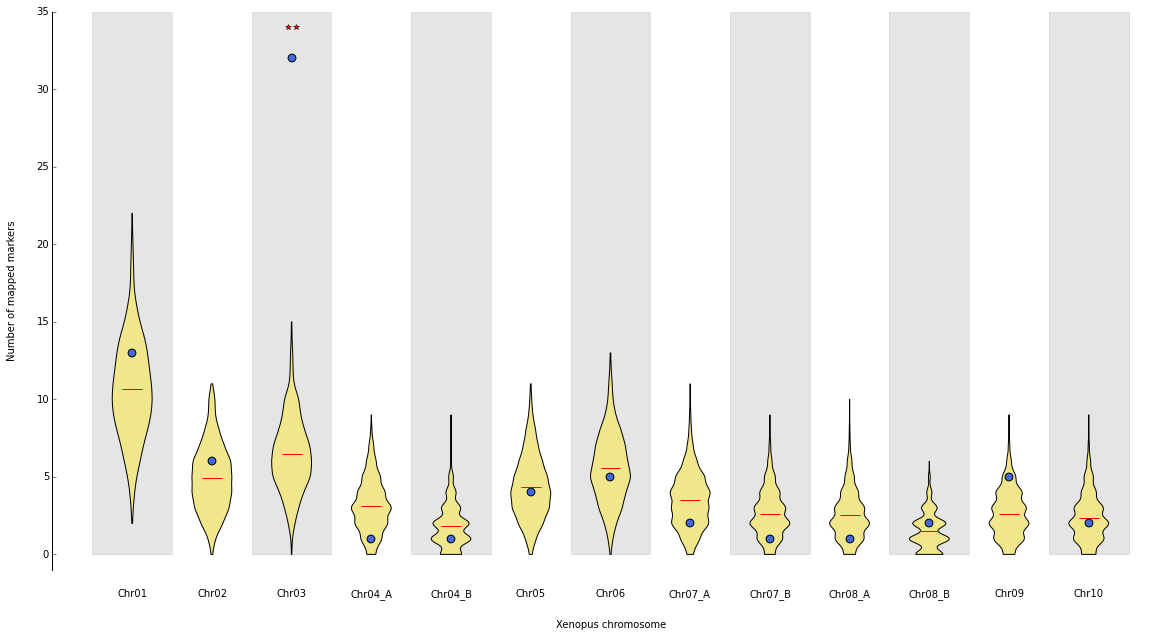

In [146]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/R_iberica_fam_SL_markers.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

### R. italica XY

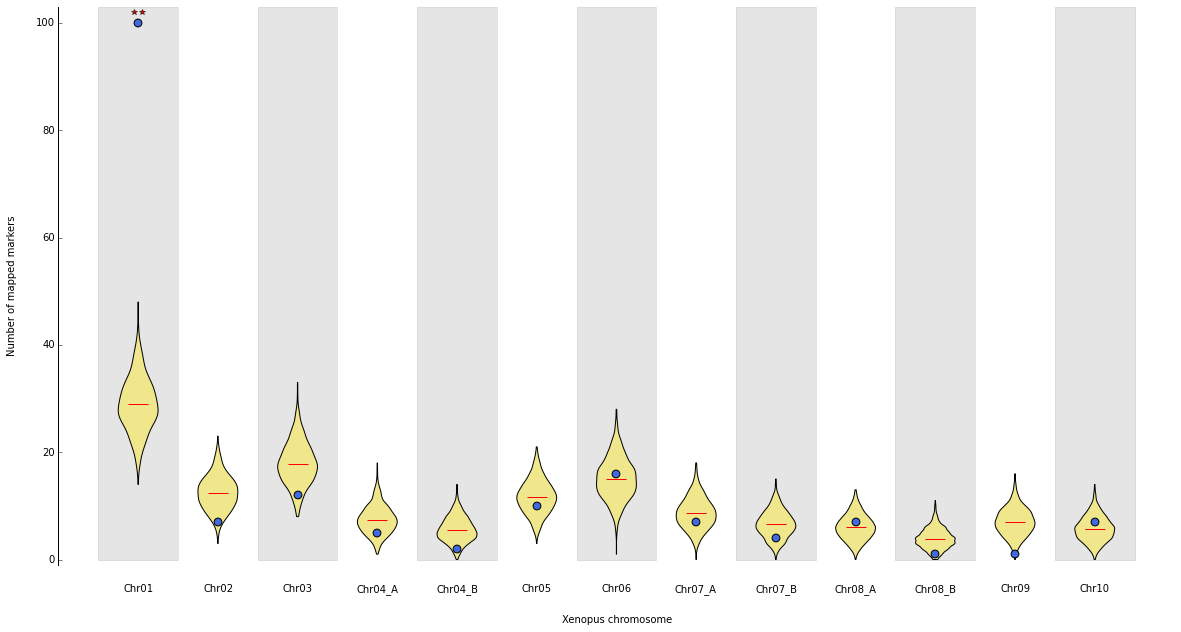

In [147]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Putative_XYlinked_makers.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

### Rana japonica 't' population

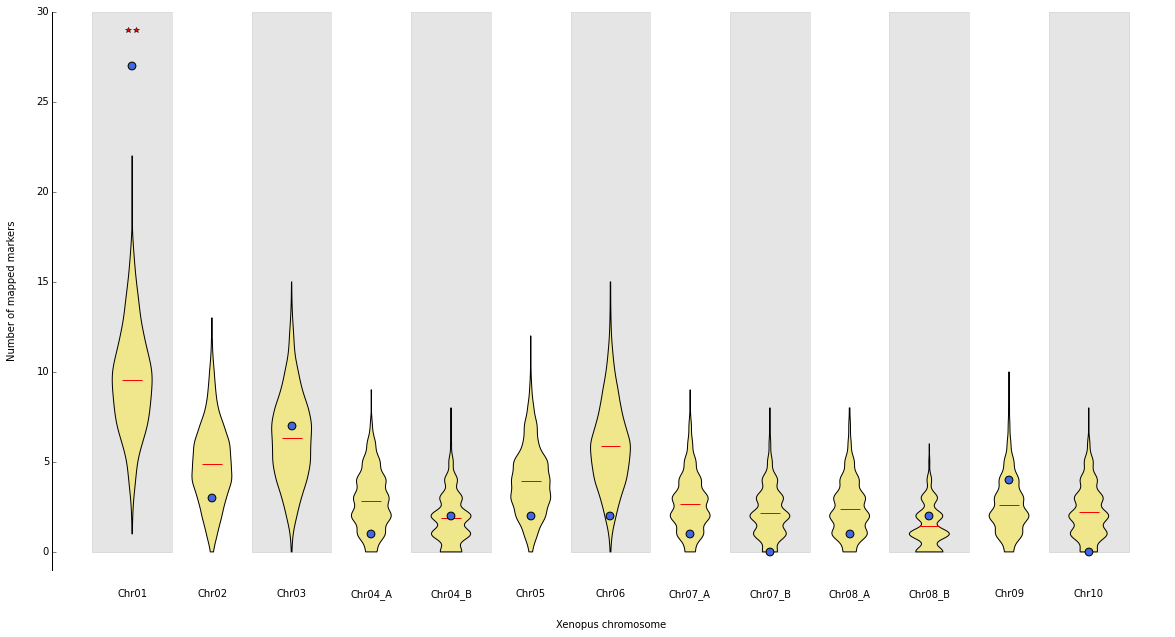

In [148]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_japonica/R_jap_pop_t.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

### Rana kukinoris Nanping

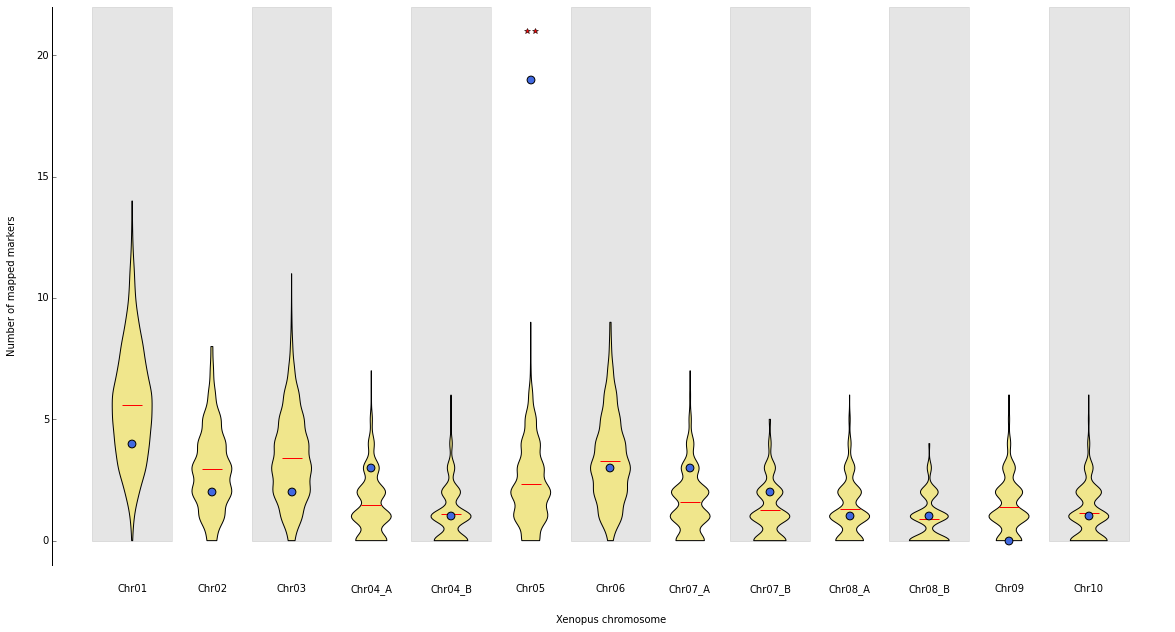

In [149]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_kukinoris/R_kukinoris_Nanping.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

### Rana ornativentris "o" population - heterozygosity method only


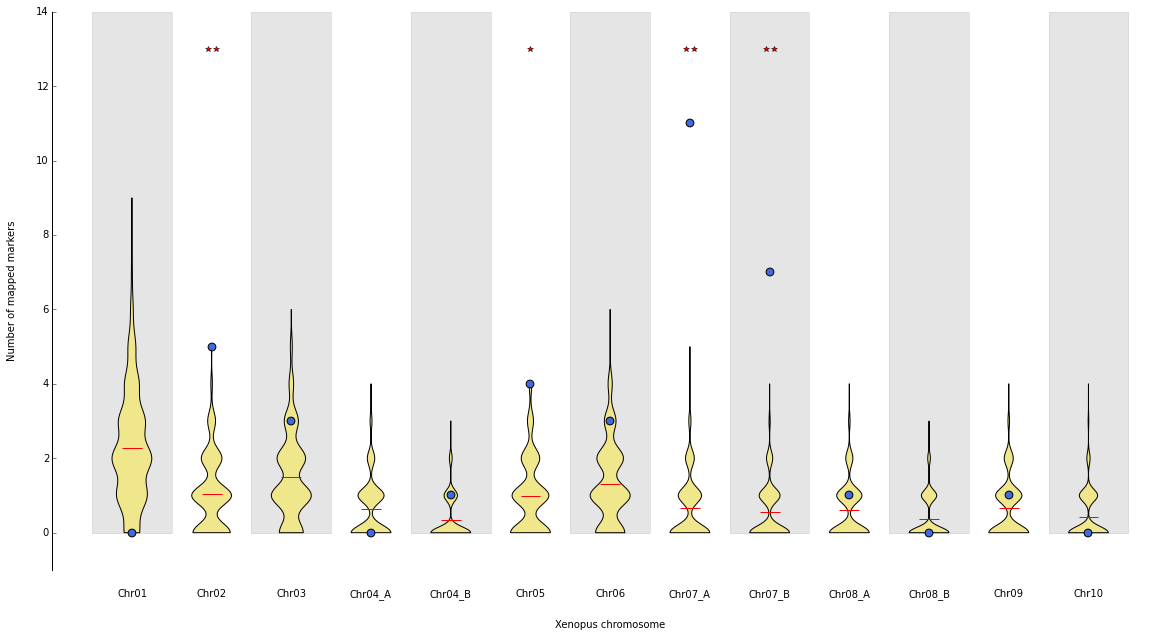

In [219]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Rornativentris/Stacks/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Rornativentris/Stacks/Putative_ZWlinked_makers_o_pop_het_only.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## L. pipiens (West)

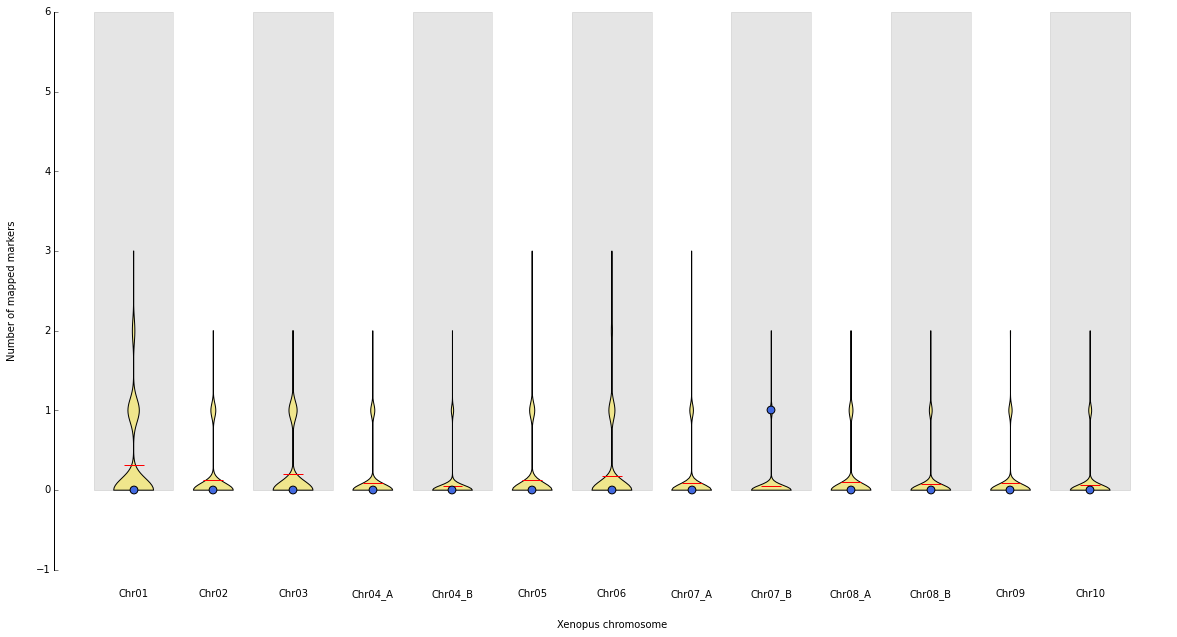

In [157]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Final_sex_linked_markers/L_pipiens_west/L_pipiens_west.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## L. tarahumarae

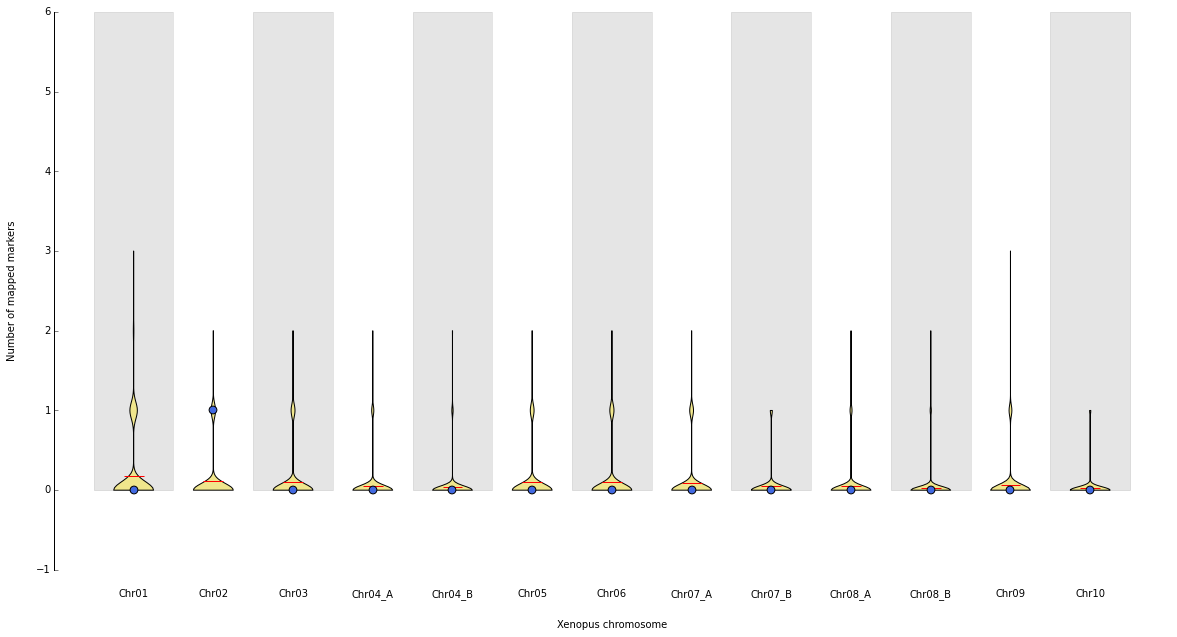

In [158]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Random_tags"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Ltarahumarae/Sex_linked_markers/Putative_XYlinked_makers.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## P. perezi

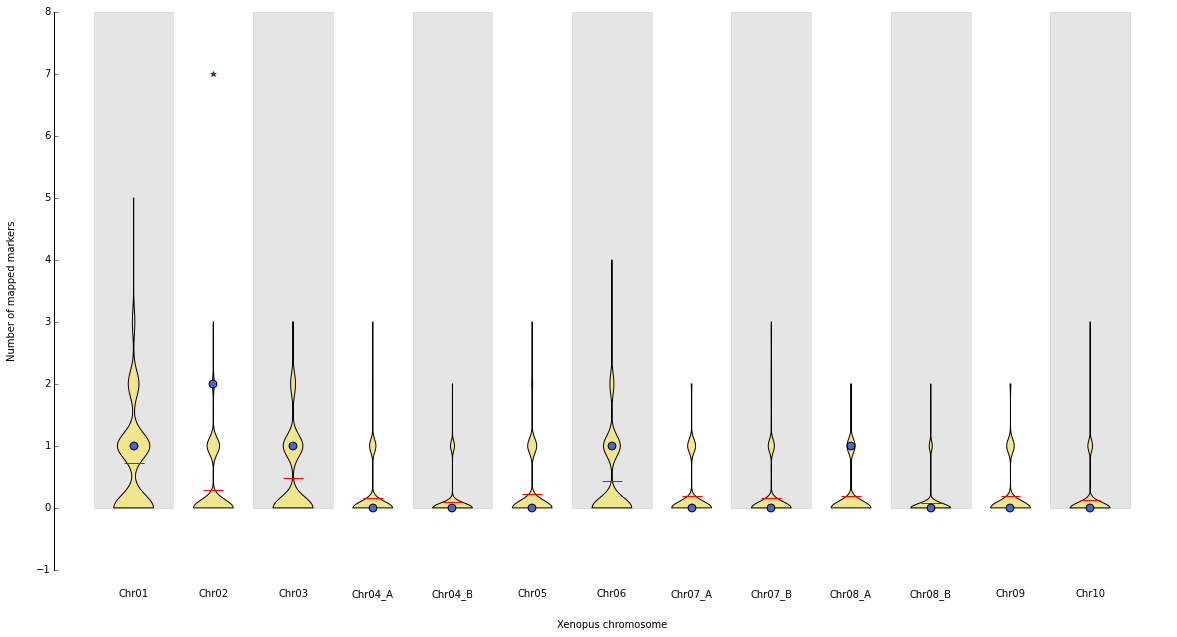

In [160]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/P_perezi/P_perezi.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)

## R. latastei - try Evalue 1e-15

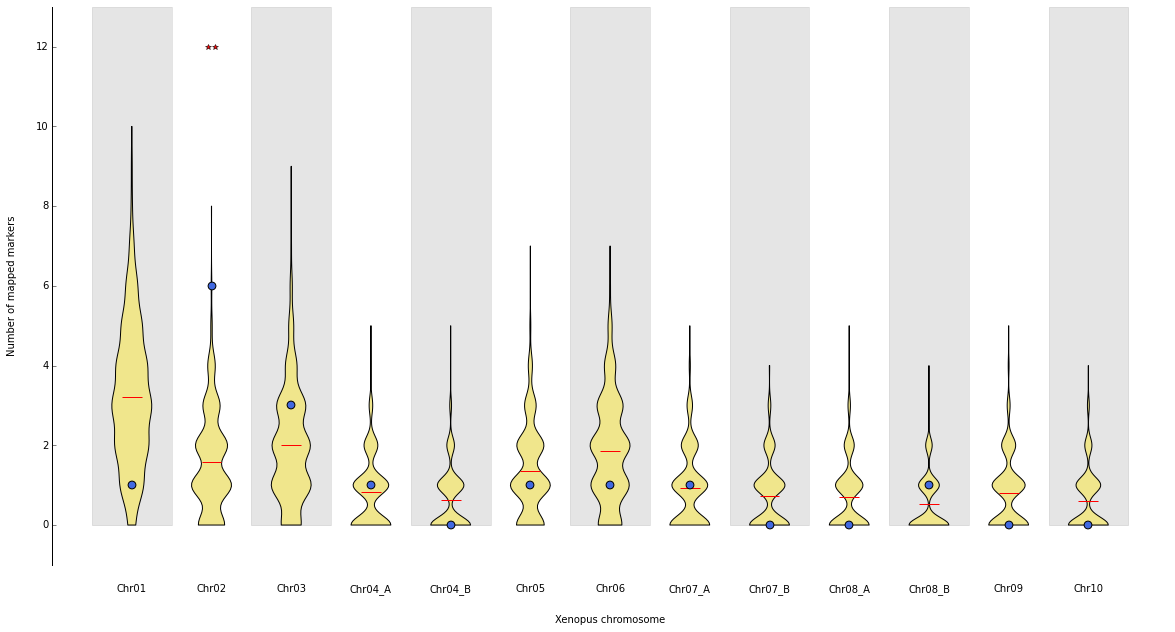

In [183]:
## Ok, so this is the workflow then . . . do this for each species. 

input_dir = "/home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Random_tags/"
SLM_mapping_path = "/home/djeffrie/Data/RADseq/Rlatastei/Populations_strict_kept2/Putative_XYlinked_makers.fa"
plot_out_path = "%s_per_chromosome_mappings.svg" %  SLM_mapping_path.rpartition(".")[0]

Genome_db_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

## Get blast out paths 

blast_out_files = Get_blast_paths(input_dir)

## Parrallelise their filtering

pool = Pool(6)

outs = pool.map(para_blastparse, blast_out_files)

## sort the mappings to chromosomes

Total_Mappings_per_chrom = sort_mappings(outs)

## Get the mappings of the real sex linked markers

Real_sorted_SLM_mappings = Real_SLM_mapper(SLM_mapping_path, Genome_db_path)

## Plot

Plot_mappings_per_chrom(Total_Mappings_per_chrom, Real_sorted_SLM_mappings, plot_out_path)